In [1]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score


In [2]:
file_path = "data/raw/CM Data Collection - Leo Cup (Responses).xlsx"
df = pd.read_excel(file_path)


In [3]:
mask = (
    (df["FINALS - Uma 1"].str.contains("Nice Nature", case=False, na=False) & df["FINALS - Uma 1 Role"].str.contains("Ace", case=False, na=False)) |
    (df["FINALS - Uma 2"].str.contains("Nice Nature", case=False, na=False) & df["FINALS - Uma 2 Role"].str.contains("Ace", case=False, na=False)) |
    (df["FINALS - Uma 3"].str.contains("Nice Nature", case=False, na=False) & df["FINALS - Uma 3 Role"].str.contains("Ace", case=False, na=False))
)

nice_nature_aces = df.loc[mask, ["Player IGN", "CM Group", "FINALS - Uma 1", "FINALS - Uma 2", "FINALS - Uma 3", "FINALS RESULTS"]]
print(nice_nature_aces)

           Player IGN           CM Group       FINALS - Uma 1  \
8                  MT  Graded (No Limit)          Nice Nature   
290            Thomas  Graded (No Limit)          Nice Nature   
580           Anadeji  Graded (No Limit)          Nice Nature   
1098         Soltasia  Graded (No Limit)          Nice Nature   
1150            Despy  Graded (No Limit)  Maruzensky (Summer)   
1262          shallty  Graded (No Limit)            Seiun Sky   
1268  ChizuruNakamura  Graded (No Limit)          Nice Nature   
1358          Legalll  Graded (No Limit)          Nice Nature   
1373             Jaya  Graded (No Limit)          Nice Nature   
1379         Majestyk  Graded (No Limit)            Gold Ship   
1414           Lilith  Graded (No Limit)          Nice Nature   
1459            Riley  Graded (No Limit)          Nice Nature   
1476          brittle  Graded (No Limit)  Maruzensky (Summer)   
1478              TJ4  Graded (No Limit)          Nice Nature   
1488            Norio  Gr

In [4]:
# Drop unnamed / empty columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns = df.columns.str.strip()


In [5]:
# Drop fully empty columns or rows
df = df.dropna(axis=1, how='all')
df = df.dropna(subset=['Select a round to fill data', 'CM Group'], how='any')

# Standardize text
df['Select a round to fill data'] = df['Select a round to fill data'].str.strip().str.title()
df['CM Group'] = df['CM Group'].str.strip().str.title()
df['FINALS RESULTS'] = df['FINALS RESULTS'].str.upper().fillna('N/A')

print(df['Select a round to fill data'].value_counts())

Select a round to fill data
End Survey    1490
Name: count, dtype: int64


In [6]:
finals_df = df[df['Select a round to fill data'].str.contains('End Survey', case=False, na=False)].copy()
finals_df = finals_df.dropna(subset=['FINALS RESULTS'])
finals_df['FINALS RESULTS'] = finals_df['FINALS RESULTS'].str.strip().str.upper()

print(finals_df[['Player IGN', 'CM Group', 'FINALS RESULTS']].head())
print(finals_df)

    Player IGN           CM Group FINALS RESULTS
0    Pharaday   Graded (No Limit)            N/A
1         Ryan  Graded (No Limit)            2ND
2        Ramen  Graded (No Limit)            1ST
3  Jackenstein  Graded (No Limit)            1ST
4         Cien  Graded (No Limit)            1ST
                   Timestamp    Player IGN           CM Group  \
0    2025-10-30 05:42:28.475     Pharaday   Graded (No Limit)   
1    2025-10-29 21:55:35.958          Ryan  Graded (No Limit)   
2    2025-10-28 21:03:08.629         Ramen  Graded (No Limit)   
3    2025-10-28 17:32:17.479   Jackenstein  Graded (No Limit)   
4    2025-11-09 12:23:05.233          Cien  Graded (No Limit)   
...                      ...           ...                ...   
1485 2025-11-10 10:26:32.428  UnwaryTuba77  Graded (No Limit)   
1486 2025-11-10 10:28:43.568          Grim  Graded (No Limit)   
1487 2025-11-10 10:29:13.871         Sakai  Graded (No Limit)   
1488 2025-11-10 10:32:19.451         Norio  Graded (No L

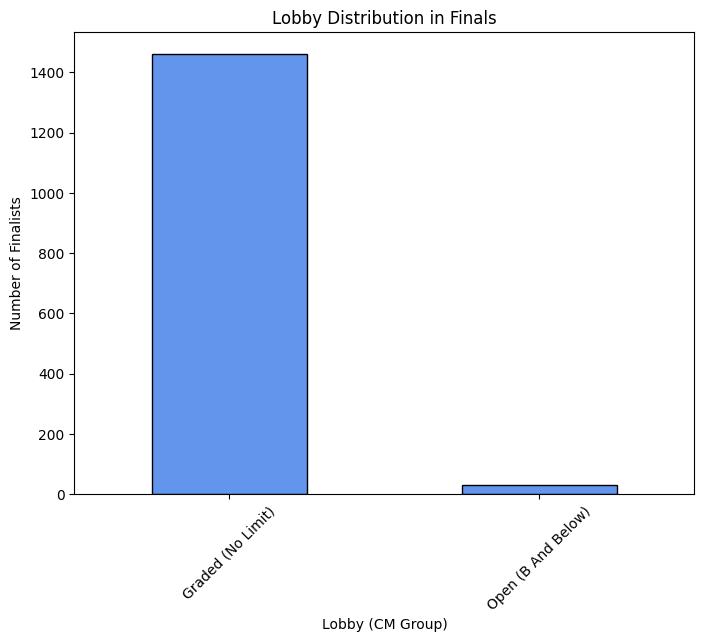

In [7]:
plt.figure(figsize=(8,6))
finals_df['CM Group'].value_counts().plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Lobby Distribution in Finals')
plt.xlabel('Lobby (CM Group)')
plt.ylabel('Number of Finalists')
plt.xticks(rotation=45)
plt.show()

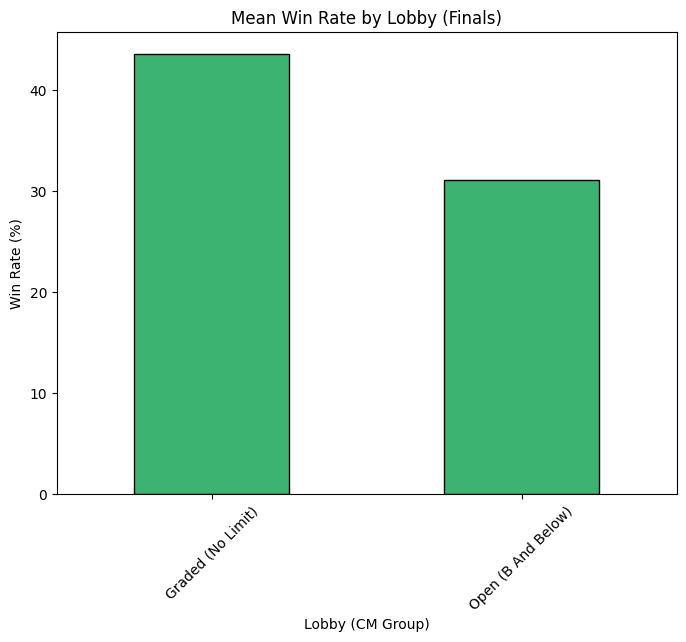

In [8]:
# Compute win rate (1ST = win)
winrate_df = finals_df.groupby('CM Group')['FINALS RESULTS'].apply(lambda x: (x == '1ST').mean() * 100)

plt.figure(figsize=(8,6))
winrate_df.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title('Mean Win Rate by Lobby (Finals)')
plt.xlabel('Lobby (CM Group)')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)
plt.show()

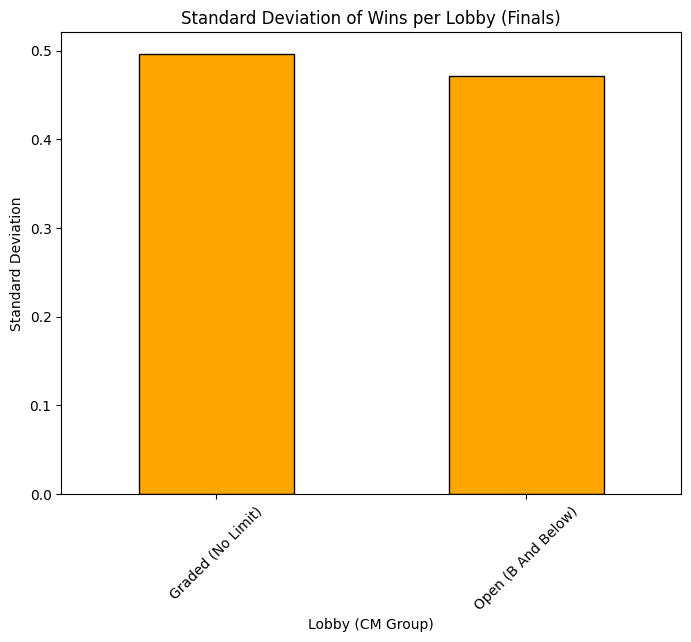

In [9]:
#We’ll convert results to 1 for wins, 0 for anything else, and show variability across lobbies.
finals_df['win_binary'] = (finals_df['FINALS RESULTS'] == '1ST').astype(int)
std_df = finals_df.groupby('CM Group')['win_binary'].std()

plt.figure(figsize=(8,6))
std_df.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Standard Deviation of Wins per Lobby (Finals)')
plt.xlabel('Lobby (CM Group)')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.show()

In [10]:
summary_df = pd.DataFrame({
    'Win Rate (%)': winrate_df.round(2),
    'Std Dev': std_df.round(3)
})
print(summary_df)

                    Win Rate (%)  Std Dev
CM Group                                 
Graded (No Limit)          43.53    0.496
Open (B And Below)         31.03    0.471


In [11]:
# Extract Finals Running Style columns
finals_styles = df[
    [
        "FINALS - Uma 1 Running Style",
        "FINALS - Uma 2 Running Style",
        "FINALS - Uma 3 Running Style",
    ]
].copy()

# Drop rows where all 3 are NaN (no data)
finals_styles.dropna(how="all", inplace=True)

# Standardize formatting
for col in finals_styles.columns:
    finals_styles[col] = finals_styles[col].str.strip().str.title()

In [12]:
all_styles = finals_styles.melt(value_name="Running Style")["Running Style"].dropna()
print(all_styles.value_counts())

Running Style
Late Surger     1055
Pace Chaser      859
Front Runner     645
End Closer       561
Name: count, dtype: int64


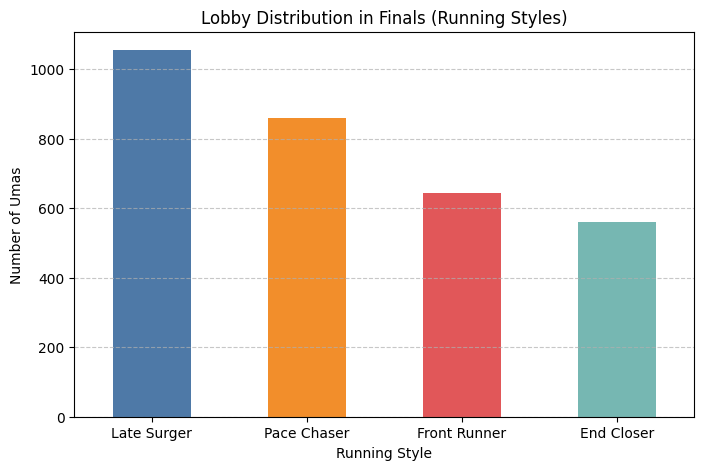

In [13]:
import matplotlib.pyplot as plt

style_counts = all_styles.value_counts()

plt.figure(figsize=(8, 5))
style_counts.plot(kind="bar", color=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"])
plt.title("Lobby Distribution in Finals (Running Styles)")
plt.xlabel("Running Style")
plt.ylabel("Number of Umas")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

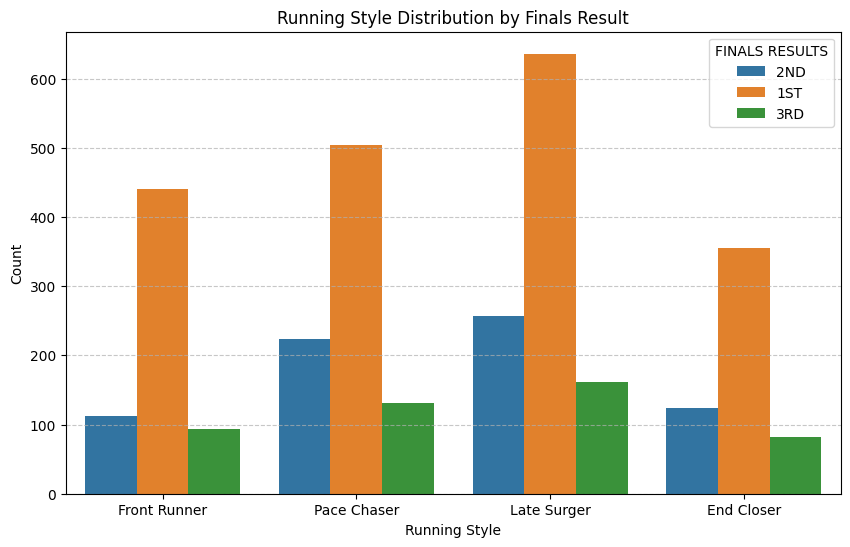

In [14]:
import seaborn as sns

# Combine style and result
melted = finals_styles.join(df["FINALS RESULTS"]).melt(
    id_vars=["FINALS RESULTS"], value_name="Running Style"
).dropna()

plt.figure(figsize=(10,6))
sns.countplot(
    data=melted,
    x="Running Style",
    hue="FINALS RESULTS",
    order=["Front Runner", "Pace Chaser", "Late Surger", "End Closer"],
)
plt.title("Running Style Distribution by Finals Result")
plt.xlabel("Running Style")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

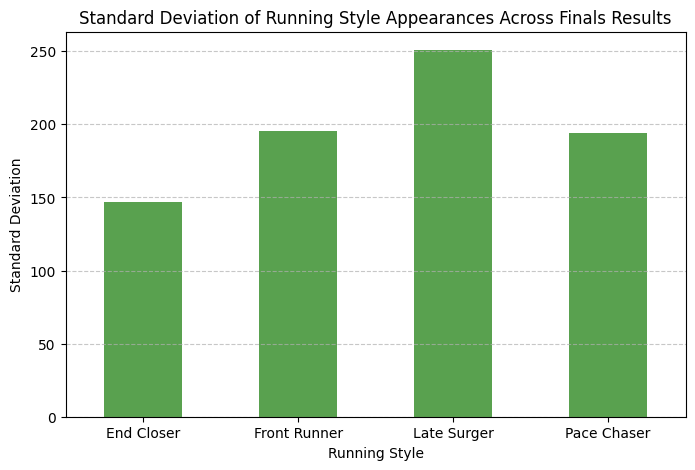

In [15]:
# Count frequencies per result
pivot = (
    melted.groupby(["FINALS RESULTS", "Running Style"])
    .size()
    .unstack(fill_value=0)
)

# Calculate standard deviation across results
std_dev = pivot.std()

plt.figure(figsize=(8, 5))
std_dev.plot(kind="bar", color="#59a14f")
plt.title("Standard Deviation of Running Style Appearances Across Finals Results")
plt.xlabel("Running Style")
plt.ylabel("Standard Deviation")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [16]:
finals = df[
    [
        "FINALS - Uma 1 Running Style",
        "FINALS - Uma 2 Running Style",
        "FINALS - Uma 3 Running Style",
    ]
].copy()

# Drop empty teams (all NaN)
finals.dropna(how="all", inplace=True)

# Standardize capitalization & spacing
for col in finals.columns:
    finals[col] = finals[col].str.strip().str.title()

In [17]:
def team_comp(row):
    # Drop NaNs and join with '-'
    styles = [s for s in row if pd.notna(s)]
    return "-".join(styles)

finals["Team Composition"] = finals.apply(team_comp, axis=1)

In [18]:
print(finals["Team Composition"].head(10))

1      Front Runner-Pace Chaser-Late Surger
2       Front Runner-Late Surger-End Closer
3         End Closer-Pace Chaser-End Closer
4         Pace Chaser-End Closer-End Closer
6     Front Runner-Front Runner-Late Surger
7      Front Runner-Front Runner-End Closer
8         Late Surger-End Closer-End Closer
9        Pace Chaser-End Closer-Late Surger
11        End Closer-Pace Chaser-End Closer
12     Front Runner-Front Runner-End Closer
Name: Team Composition, dtype: object


In [19]:
def shorten(comp):
    return (
        comp.replace("Front Runner", "Front")
        .replace("Pace Chaser", "Pace")
        .replace("Late Surger", "Late")
        .replace("End Closer", "End")
    )

finals["Team Composition"] = finals["Team Composition"].apply(shorten)

In [20]:
print(finals["Team Composition"].head(10))

1      Front-Pace-Late
2       Front-Late-End
3         End-Pace-End
4         Pace-End-End
6     Front-Front-Late
7      Front-Front-End
8         Late-End-End
9        Pace-End-Late
11        End-Pace-End
12     Front-Front-End
Name: Team Composition, dtype: object


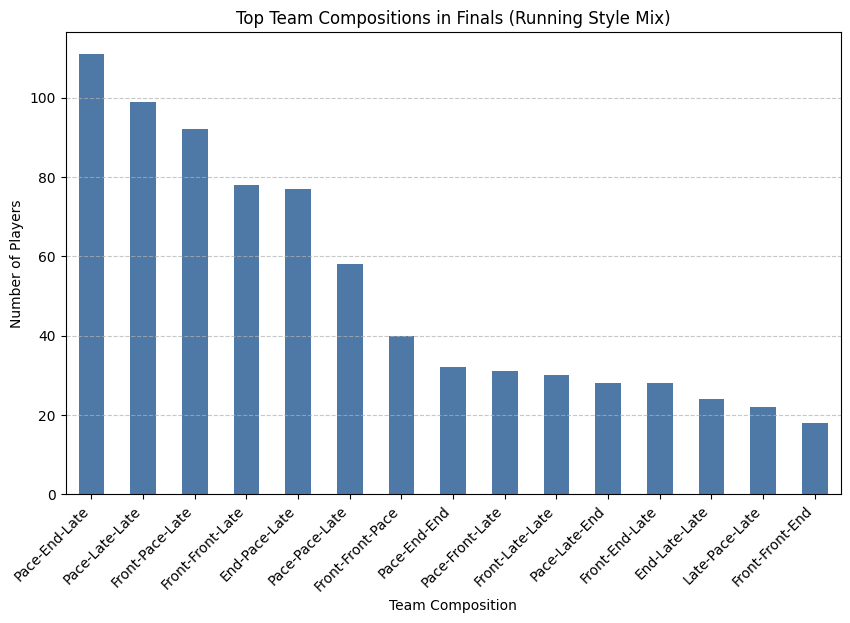

In [21]:
team_counts = finals["Team Composition"].value_counts().head(15)  # top 15 most common

plt.figure(figsize=(10,6))
team_counts.plot(kind="bar", color="#4e79a7")
plt.title("Top Team Compositions in Finals (Running Style Mix)")
plt.xlabel("Team Composition")
plt.ylabel("Number of Players")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

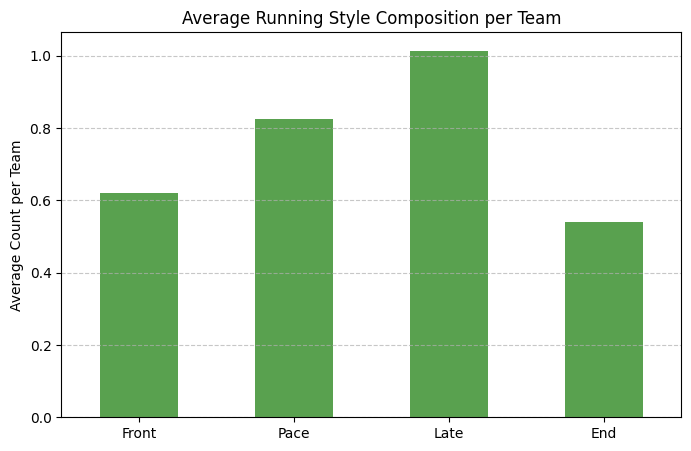

In [22]:
style_columns = ["Front", "Pace", "Late", "End"]
for style in style_columns:
    finals[style] = finals["Team Composition"].str.count(style)

# Group summary (mean number of each type per team)
team_summary = finals[style_columns].mean()

team_summary.plot(kind="bar", color="#59a14f", figsize=(8,5))
plt.title("Average Running Style Composition per Team")
plt.ylabel("Average Count per Team")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

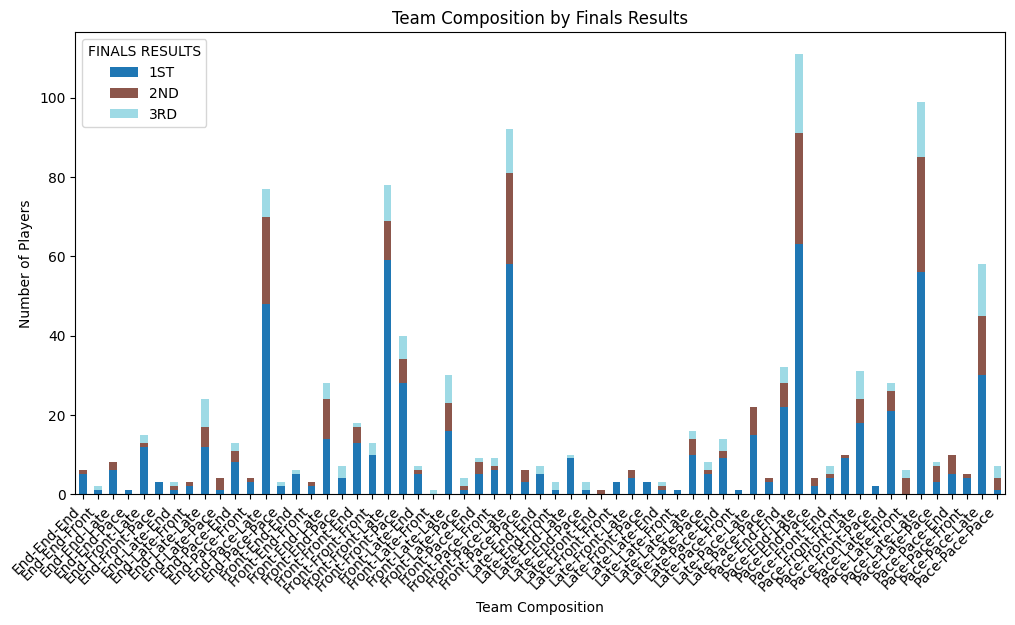

In [23]:
finals["FINALS RESULTS"] = df["FINALS RESULTS"]

# Count team composition by result
composition_results = (
    finals.groupby(["Team Composition", "FINALS RESULTS"])
    .size()
    .unstack(fill_value=0)
)

composition_results.plot(
    kind="bar",
    stacked=True,
    figsize=(12,6),
    colormap="tab20",
)
plt.title("Team Composition by Finals Results")
plt.xlabel("Team Composition")
plt.ylabel("Number of Players")
plt.xticks(rotation=45, ha="right")
plt.show()

In [24]:
# Add finals results to our team composition DataFrame
finals["FINALS RESULTS"] = df["FINALS RESULTS"]

# Filter out invalid or missing results
finals = finals.dropna(subset=["FINALS RESULTS", "Team Composition"])
finals["FINALS RESULTS"] = finals["FINALS RESULTS"].str.strip().str.upper()

# Mark winners as 1, others as 0
finals["Win"] = (finals["FINALS RESULTS"] == "1ST").astype(int)

# Group by team composition
wr_table = (
    finals.groupby("Team Composition")["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Total Teams", "sum": "Wins", "mean": "Win Rate"})
)

# Convert WR to %
wr_table["Win Rate"] = (wr_table["Win Rate"] * 100).round(2)
wr_table = wr_table.sort_values(by="Win Rate", ascending=False)

print(wr_table)

                  Total Teams  Wins  Win Rate
Team Composition                             
End-End-Pace                1     1    100.00
End-Front-Pace              3     3    100.00
Late-Late-Front             1     1    100.00
Late-Pace-Front             1     1    100.00
Late-Front-Front            3     3    100.00
...                       ...   ...       ...
Front-Late-Pace             4     1     25.00
Pace-Pace-Pace              7     1     14.29
Front-Late-Front            1     0      0.00
Late-Front-End              1     0      0.00
Pace-Late-Front             6     0      0.00

[61 rows x 3 columns]


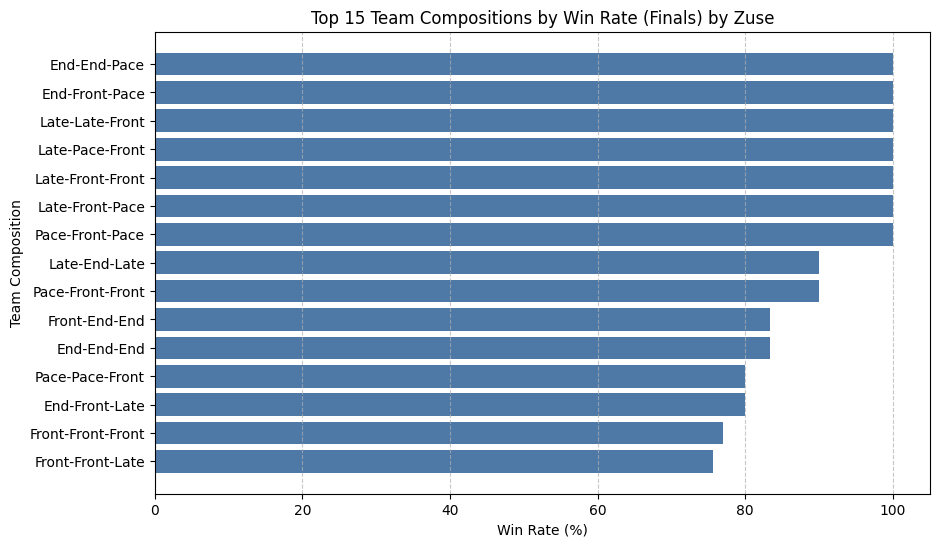

In [25]:
top_wr = wr_table.head(15)

plt.figure(figsize=(10,6))
plt.barh(top_wr.index, top_wr["Win Rate"], color="#4e79a7")
plt.title("Top 15 Team Compositions by Win Rate (Finals) by Zuse")
plt.xlabel("Win Rate (%)")
plt.ylabel("Team Composition")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [26]:
wr_table_display = wr_table.copy()
wr_table_display = wr_table_display[['Total Teams', 'Win Rate']].sort_values(by='Total Teams', ascending=False)
print(wr_table_display.head(20))

                   Total Teams  Win Rate
Team Composition                        
Pace-End-Late              111     56.76
Pace-Late-Late              99     56.57
Front-Pace-Late             92     63.04
Front-Front-Late            78     75.64
End-Pace-Late               77     62.34
Pace-Pace-Late              58     51.72
Front-Front-Pace            40     70.00
Pace-End-End                32     68.75
Pace-Front-Late             31     58.06
Front-Late-Late             30     53.33
Front-End-Late              28     50.00
Pace-Late-End               28     75.00
End-Late-Late               24     50.00
Late-Pace-Late              22     68.18
Front-Front-End             18     72.22
Late-Late-Late              16     62.50
End-Front-Late              15     80.00
Late-Pace-End               14     64.29
End-Pace-End                13     61.54
Front-Front-Front           13     76.92


/tmp/ipykernel_15247/1662554866.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_wr.index, rotation=45, ha='right')


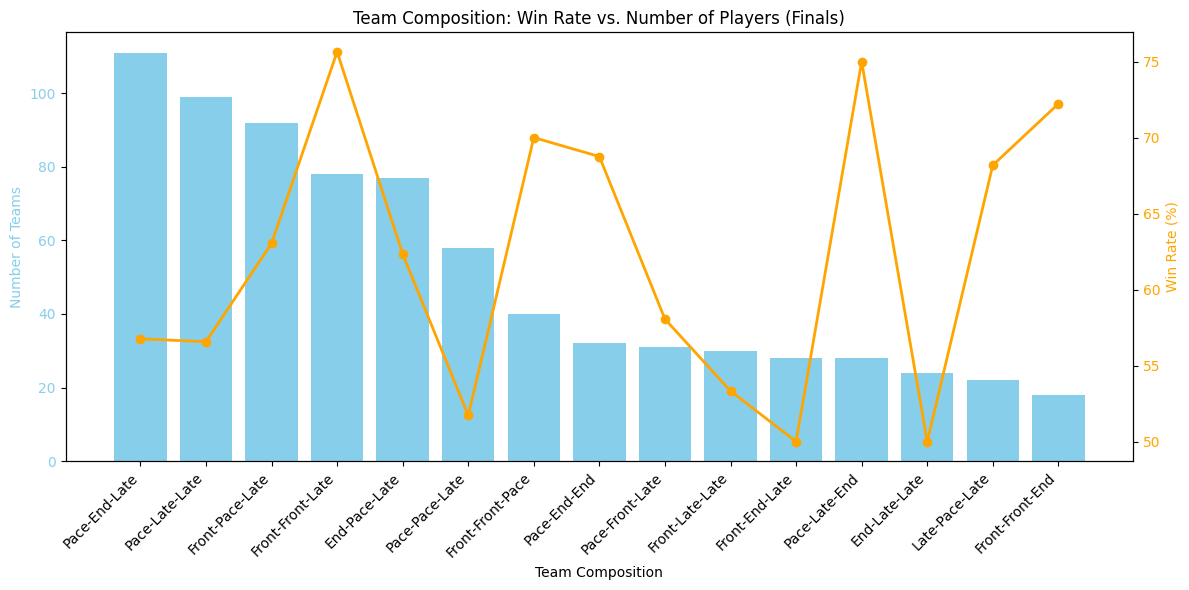

In [27]:
# Sort by team popularity
sorted_wr = wr_table.sort_values('Total Teams', ascending=False).head(15)

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar chart for team count
ax1.bar(sorted_wr.index, sorted_wr['Total Teams'], color='skyblue', label='Number of Teams')
ax1.set_xlabel('Team Composition')
ax1.set_ylabel('Number of Teams', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(sorted_wr.index, rotation=45, ha='right')

# Line chart for Win Rate
ax2 = ax1.twinx()
ax2.plot(sorted_wr.index, sorted_wr['Win Rate'], color='orange', marker='o', linewidth=2, label='Win Rate (%)')
ax2.set_ylabel('Win Rate (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Team Composition: Win Rate vs. Number of Players (Finals)')
fig.tight_layout()
plt.show()

In [28]:
wr_focus = wr_table[['Total Teams', 'Win Rate']].sort_values(by='Win Rate', ascending=False)
print(wr_focus.head(20))

                   Total Teams  Win Rate
Team Composition                        
End-End-Pace                 1    100.00
End-Front-Pace               3    100.00
Late-Late-Front              1    100.00
Late-Pace-Front              1    100.00
Late-Front-Front             3    100.00
Late-Front-Pace              3    100.00
Pace-Front-Pace              2    100.00
Late-End-Late               10     90.00
Pace-Front-Front            10     90.00
Front-End-End                6     83.33
End-End-End                  6     83.33
Pace-Pace-Front              5     80.00
End-Front-Late              15     80.00
Front-Front-Front           13     76.92
Front-Front-Late            78     75.64
End-Pace-Front               4     75.00
End-End-Late                 8     75.00
Pace-Late-End               28     75.00
Late-Pace-Pace               4     75.00
Front-Front-End             18     72.22


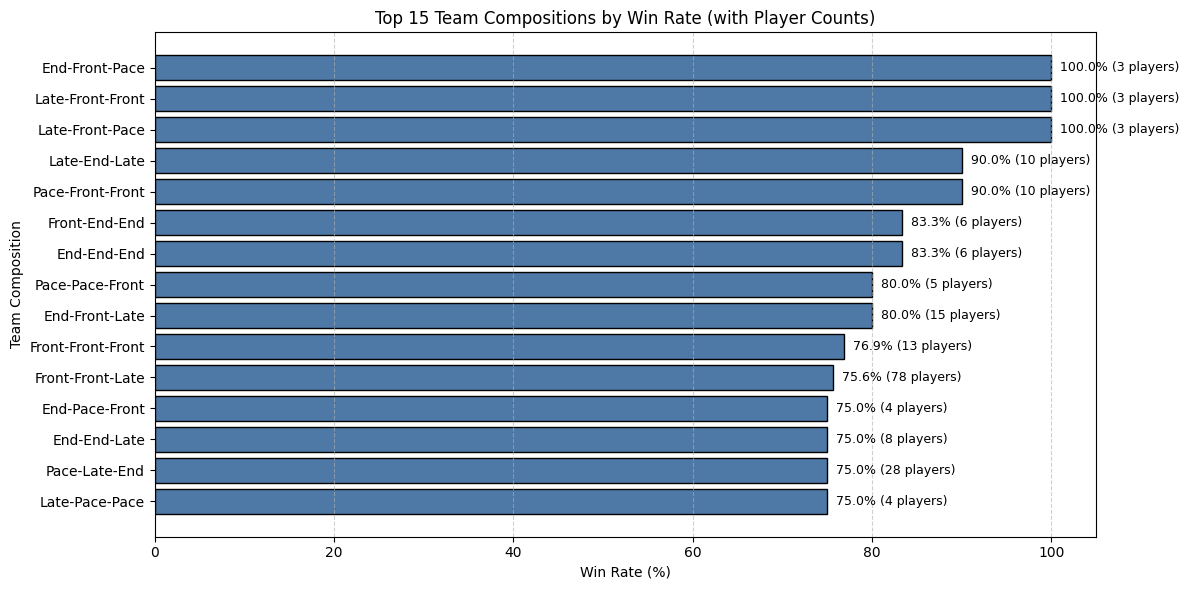

In [29]:
# Filter to avoid 1-off flukes (optional)
filtered_wr = wr_table[wr_table['Total Teams'] >= 3]  # only show comps with ≥3 teams

# Sort by Win Rate (descending)
sorted_wr = filtered_wr.sort_values('Win Rate', ascending=False).head(15)

# Create the chart
plt.figure(figsize=(12,6))
bars = plt.barh(sorted_wr.index, sorted_wr['Win Rate'], color='#4e79a7', edgecolor='black')

plt.title('Top 15 Team Compositions by Win Rate (with Player Counts)')
plt.xlabel('Win Rate (%)')
plt.ylabel('Team Composition')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate with both WR and number of players
for i, (wr, total) in enumerate(zip(sorted_wr['Win Rate'], sorted_wr['Total Teams'])):
    plt.text(wr + 1, i, f'{wr:.1f}% ({total} players)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [30]:
def normalize_team(comp):
    # Split by dash, sort alphabetically, then join back
    if pd.isna(comp):
        return np.nan
    parts = comp.split('-')
    parts = sorted(parts)
    return '-'.join(parts)

finals["Team Composition"] = finals["Team Composition"].apply(normalize_team)

In [31]:
wr_table = (
    finals.groupby("Team Composition")["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Total Teams", "sum": "Wins", "mean": "Win Rate"})
)
wr_table["Win Rate"] = (wr_table["Win Rate"] * 100).round(2)
wr_table = wr_table.sort_values(by="Win Rate", ascending=False)

print(wr_table.head(15))

                   Total Teams  Wins  Win Rate
Team Composition                              
End-End-End                  6     5     83.33
Front-Front-Front           13    10     76.92
Front-Front-Late            82    62     75.61
End-End-Front                8     6     75.00
Front-Front-Pace            59    43     72.88
End-Front-Front             21    15     71.43
Front-Pace-Pace             13     9     69.23
End-End-Pace                46    31     67.39
End-End-Late                18    12     66.67
End-Front-Pace              30    19     63.33
Late-Late-Late              16    10     62.50
End-Late-Pace              237   143     60.34
End-Front-Late              57    34     59.65
End-Late-Late               37    22     59.46
Front-Late-Pace            137    81     59.12


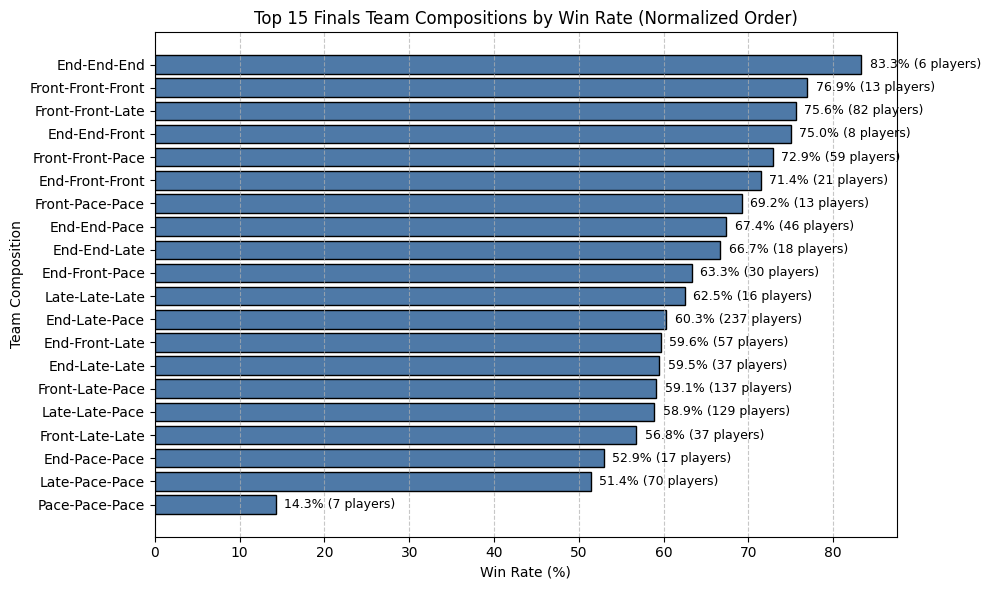

In [32]:
top_wr = wr_table.sort_values('Win Rate', ascending=False)

plt.figure(figsize=(10,6))
bars = plt.barh(top_wr.index, top_wr['Win Rate'], color='#4e79a7', edgecolor='black')
plt.title('Top 15 Finals Team Compositions by Win Rate (Normalized Order)')
plt.xlabel('Win Rate (%)')
plt.ylabel('Team Composition')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, (wr, total) in enumerate(zip(top_wr['Win Rate'], top_wr['Total Teams'])):
    plt.text(wr + 1, i, f'{wr:.1f}% ({total} players)', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [33]:
# Extract Finals Uma + Role columns
uma_cols = [
    ["FINALS - Uma 1", "FINALS - Uma 1 Role"],
    ["FINALS - Uma 2", "FINALS - Uma 2 Role"],
    ["FINALS - Uma 3", "FINALS - Uma 3 Role"],
]

# Create a unified list of (Uma, Role, Result)
uma_data = []

for i in range(1, 4):
    temp = df[[f"FINALS - Uma {i}", f"FINALS - Uma {i} Role", "FINALS RESULTS"]].copy()
    temp.columns = ["Uma", "Role", "Result"]
    uma_data.append(temp)

# Combine all into one DataFrame
uma_df = pd.concat(uma_data, ignore_index=True)

In [34]:
# Drop empty rows and clean text
uma_df = uma_df.dropna(subset=["Uma", "Role", "Result"])
uma_df["Uma"] = uma_df["Uma"].str.strip().str.title()
uma_df["Role"] = uma_df["Role"].str.strip().str.title()
uma_df["Result"] = uma_df["Result"].str.upper().str.strip()

# Add binary Win column
uma_df["Win"] = (uma_df["Result"] == "1ST").astype(int)


In [35]:
# Aggregate performance by Uma
uma_wr = (
    uma_df.groupby("Uma")["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Appearances", "sum": "Wins", "mean": "Win Rate"})
)
uma_wr["Win Rate"] = (uma_wr["Win Rate"] * 100).round(2)

# Aggregate performance by Role
role_wr = (
    uma_df.groupby("Role")["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Appearances", "sum": "Wins", "mean": "Win Rate"})
)
role_wr["Win Rate"] = (role_wr["Win Rate"] * 100).round(2)


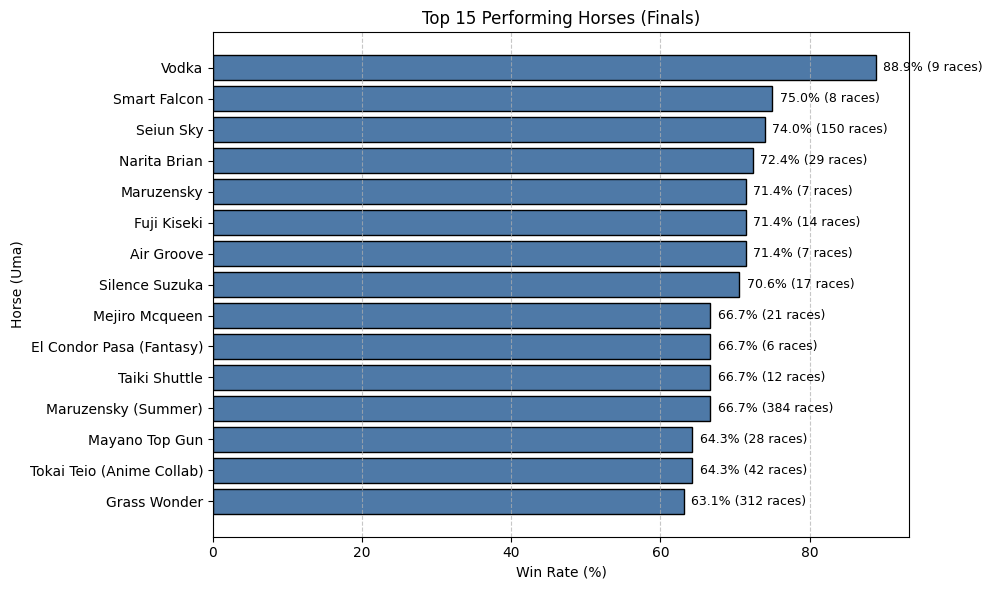

In [36]:
import matplotlib.pyplot as plt

top_uma = uma_wr[uma_wr["Appearances"] >= 5].sort_values("Win Rate", ascending=False).head(15)

plt.figure(figsize=(10,6))
bars = plt.barh(top_uma.index, top_uma["Win Rate"], color="#4e79a7", edgecolor="black")
plt.title("Top 15 Performing Horses (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Horse (Uma)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Annotate with WR and count
for i, (wr, total) in enumerate(zip(top_uma["Win Rate"], top_uma["Appearances"])):
    plt.text(wr + 1, i, f"{wr:.1f}% ({total} races)", va="center", fontsize=9)

plt.tight_layout()
plt.show()


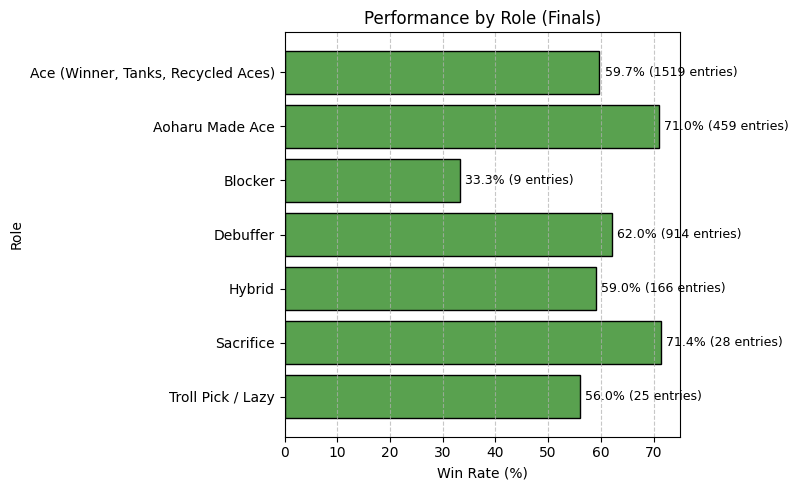

In [37]:
plt.figure(figsize=(8,5))
bars = plt.barh(role_wr.index, role_wr["Win Rate"], color="#59a14f", edgecolor="black")
plt.title("Performance by Role (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Role")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Annotate with WR and appearances
for i, (wr, total) in enumerate(zip(role_wr["Win Rate"], role_wr["Appearances"])):
    plt.text(wr + 1, i, f"{wr:.1f}% ({total} entries)", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [38]:
# Group by Uma + Role combination
pair_wr = (
    uma_df.groupby(["Uma", "Role"])["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Appearances", "sum": "Wins", "mean": "Win Rate"})
)
pair_wr["Win Rate"] = (pair_wr["Win Rate"] * 100).round(2)

# Filter to meaningful samples (e.g., at least 3 appearances)
top_pairs = pair_wr[pair_wr["Appearances"] >= 3].sort_values("Win Rate", ascending=False).head(20)
print(top_pairs)

                                                             Appearances  \
Uma                      Role                                              
Nice Nature              Aoharu Made Ace                               4   
Narita Brian             Aoharu Made Ace                               4   
Mayano Top Gun           Sacrifice                                     3   
Vodka                    Ace (Winner, Tanks, Recycled Aces)            8   
Mayano Top Gun (Wedding) Ace (Winner, Tanks, Recycled Aces)            7   
Silence Suzuka           Aoharu Made Ace                               7   
Seiun Sky                Sacrifice                                    14   
Nice Nature              Ace (Winner, Tanks, Recycled Aces)           11   
Seiun Sky                Aoharu Made Ace                              32   
Smart Falcon             Ace (Winner, Tanks, Recycled Aces)            5   
Fuji Kiseki              Ace (Winner, Tanks, Recycled Aces)           10   
Nice Nature 

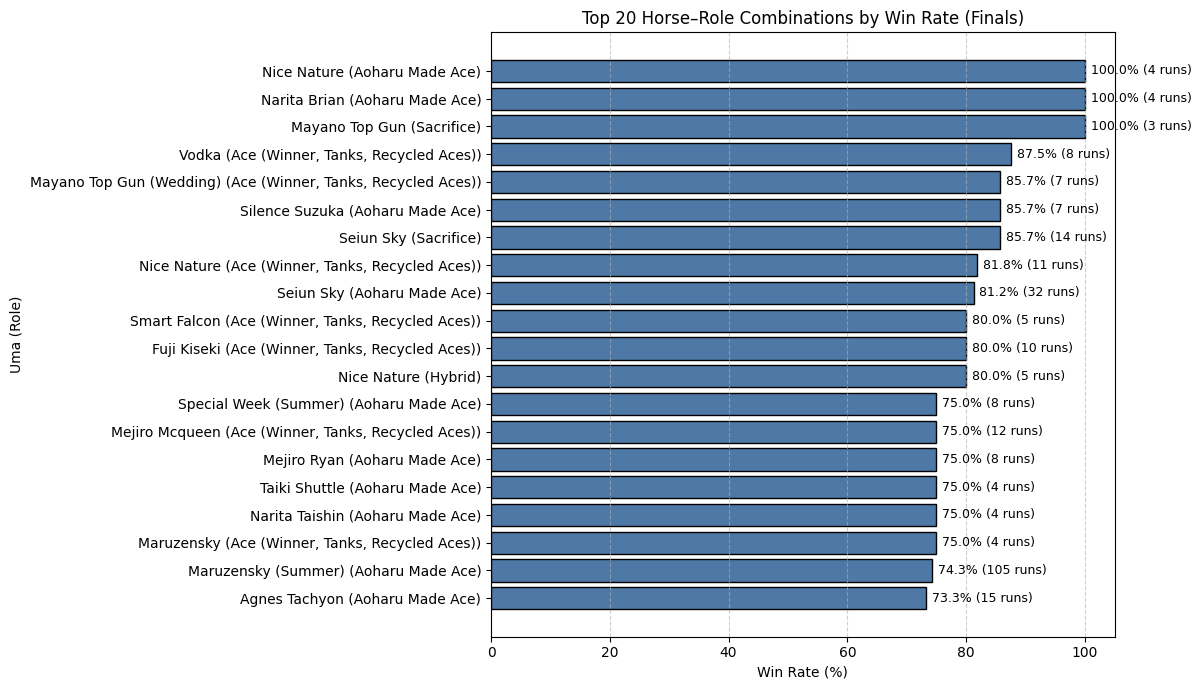

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
bars = plt.barh(
    [f"{uma} ({role})" for uma, role in top_pairs.index],
    top_pairs["Win Rate"],
    color="#4e79a7",
    edgecolor="black"
)

plt.title("Top 20 Horse–Role Combinations by Win Rate (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Uma (Role)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Add WR and sample count
for i, (wr, total) in enumerate(zip(top_pairs["Win Rate"], top_pairs["Appearances"])):
    plt.text(wr + 1, i, f"{wr:.1f}% ({total} runs)", va="center", fontsize=9)

plt.tight_layout()
plt.show()

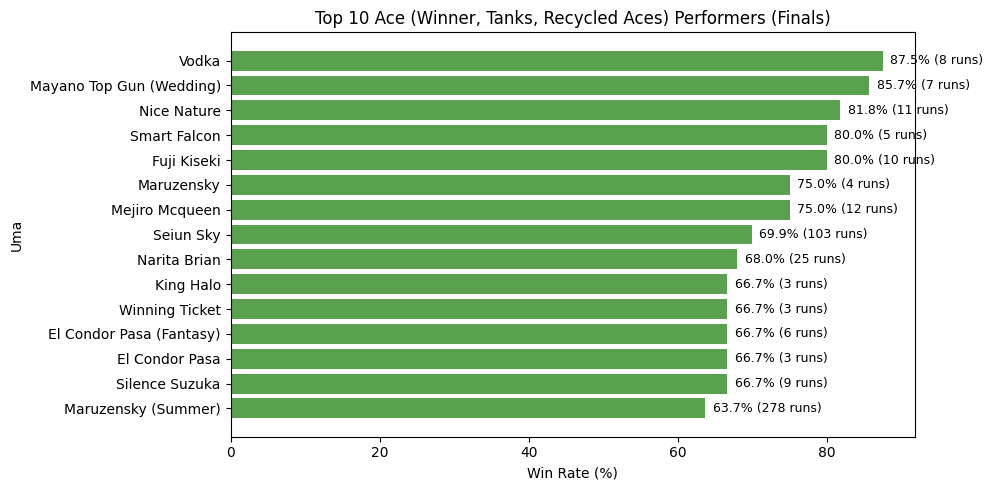

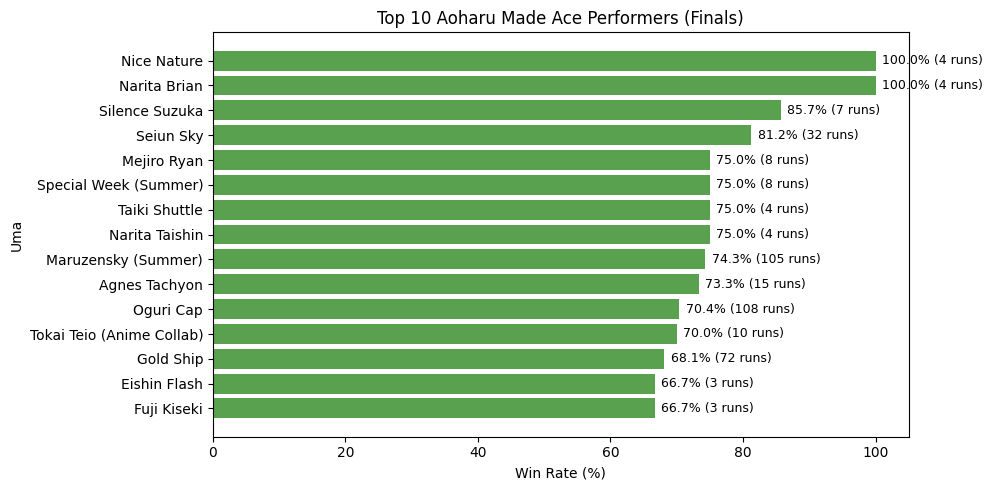

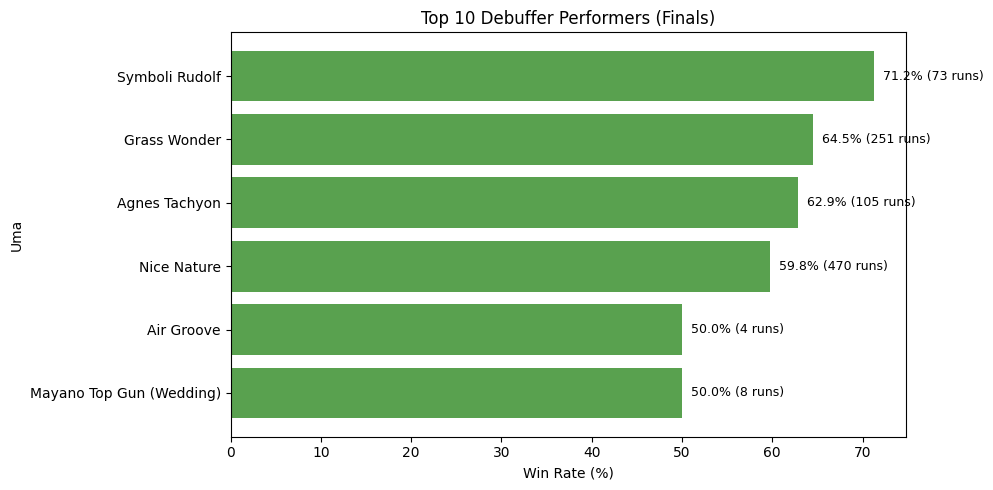

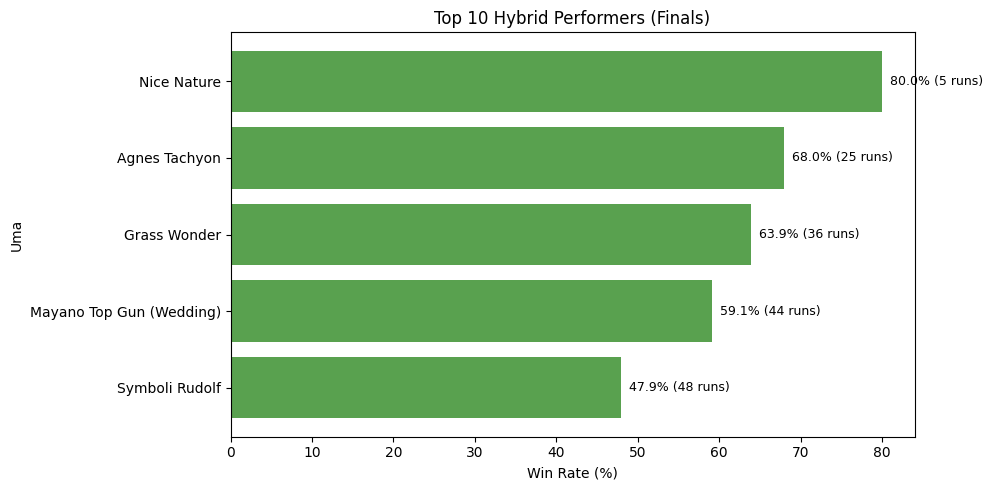

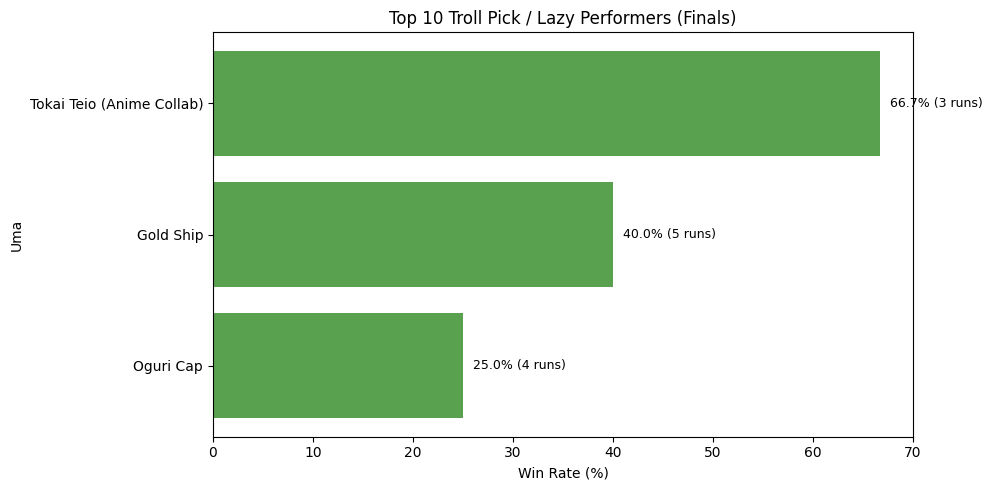

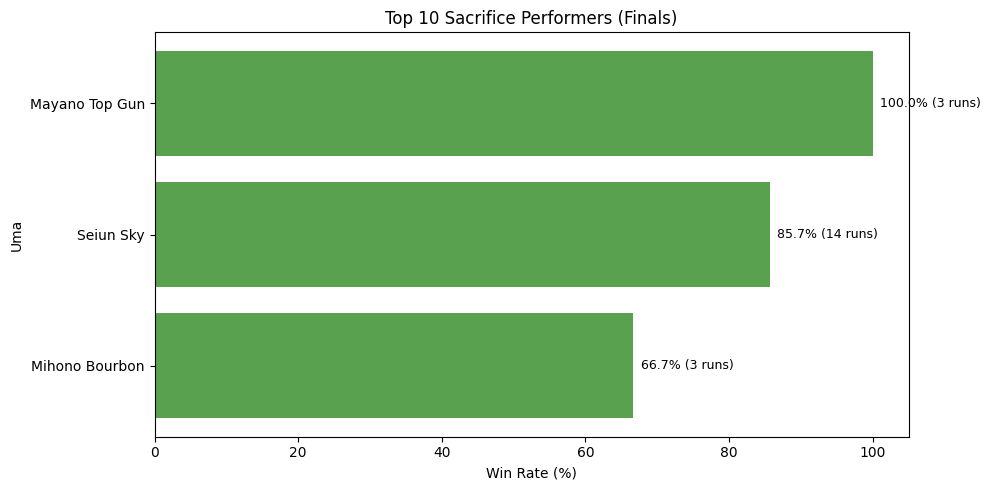

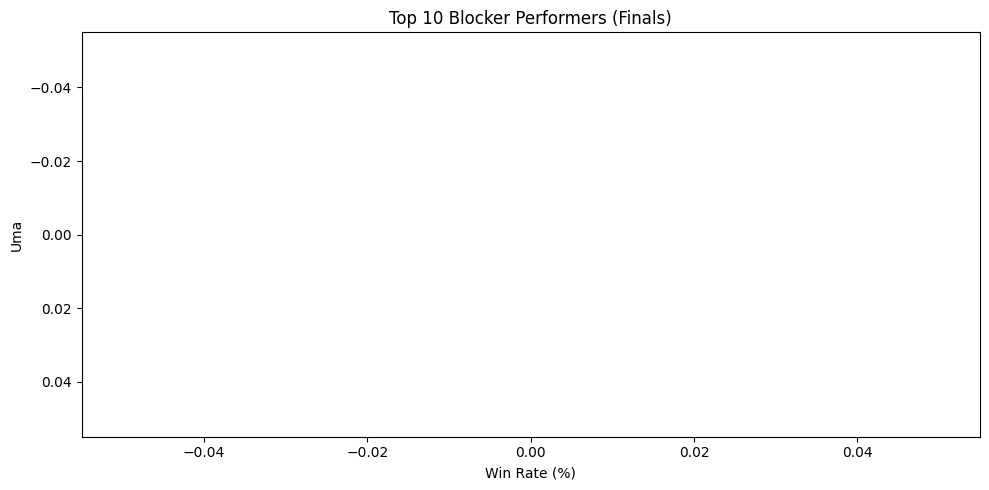

In [40]:
for role in uma_df["Role"].unique():
    subset = pair_wr.loc[pair_wr.index.get_level_values("Role") == role]
    top_subset = subset[subset["Appearances"] >= 3].sort_values("Win Rate", ascending=False).head(15)

    plt.figure(figsize=(10,5))
    plt.barh(top_subset.index.get_level_values("Uma"), top_subset["Win Rate"], color="#59a14f")
    plt.title(f"Top 10 {role} Performers (Finals)")
    plt.xlabel("Win Rate (%)")
    plt.ylabel("Uma")
    plt.gca().invert_yaxis()
    for i, (wr, total) in enumerate(zip(top_subset["Win Rate"], top_subset["Appearances"])):
        plt.text(wr + 1, i, f"{wr:.1f}% ({total} runs)", va="center", fontsize=9)
    plt.tight_layout()
    plt.show()

In [41]:
# Extract all relevant Finals columns
merged_data = []

for i in range(1, 4):
    temp = df[
        [
            f"FINALS - Uma {i}",
            f"FINALS - Uma {i} Role",
            f"FINALS - Uma {i} Running Style",
            "FINALS RESULTS",
        ]
    ].copy()
    temp.columns = ["Uma", "Role", "Running Style", "Result"]
    merged_data.append(temp)

# Combine into a single DataFrame
role_style_df = pd.concat(merged_data, ignore_index=True)

In [42]:
role_style_df = role_style_df.dropna(subset=["Uma", "Role", "Running Style", "Result"])
role_style_df["Uma"] = role_style_df["Uma"].str.strip().str.title()
role_style_df["Role"] = role_style_df["Role"].str.strip().str.title()
role_style_df["Running Style"] = role_style_df["Running Style"].str.strip().str.title()
role_style_df["Result"] = role_style_df["Result"].str.upper().str.strip()

# Add binary win flag
role_style_df["Win"] = (role_style_df["Result"] == "1ST").astype(int)


In [43]:
role_style_wr = (
    role_style_df.groupby(["Role", "Running Style"])["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Appearances", "sum": "Wins", "mean": "Win Rate"})
)
role_style_wr["Win Rate"] = (role_style_wr["Win Rate"] * 100).round(2)
role_style_wr = role_style_wr.sort_values("Win Rate", ascending=False)
print(role_style_wr.head(10))


                                 Appearances  Wins  Win Rate
Role              Running Style                             
Blocker           End Closer               1     1    100.00
Troll Pick / Lazy Front Runner             1     1    100.00
                  Late Surger              6     5     83.33
Sacrifice         Front Runner            25    19     76.00
Aoharu Made Ace   Front Runner           156   118     75.64
Debuffer          End Closer             125    91     72.80
Aoharu Made Ace   Pace Chaser            179   125     69.83
                  Late Surger             46    31     67.39
                  End Closer              78    52     66.67
Debuffer          Pace Chaser             15    10     66.67


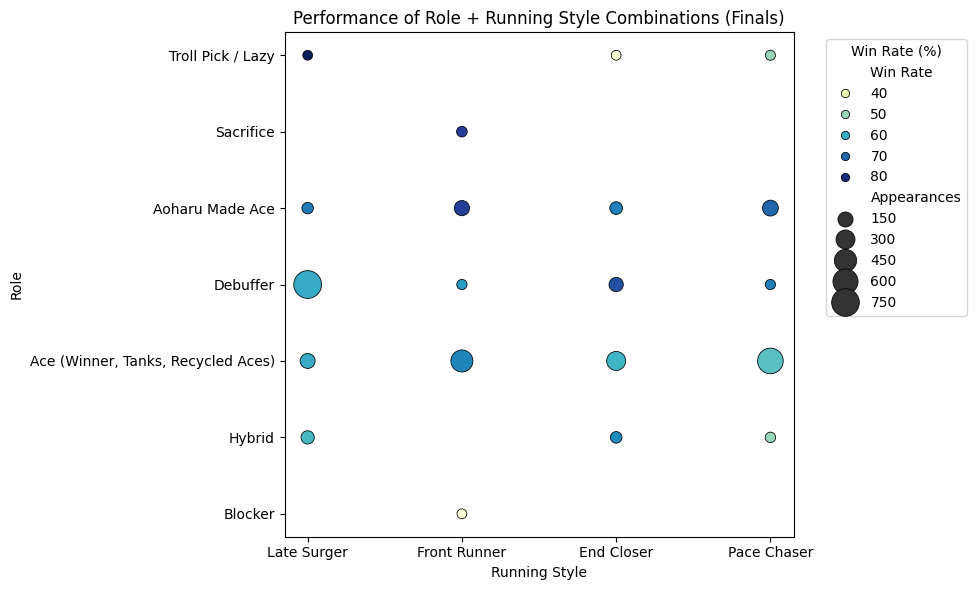

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only keep combos with a minimum number of appearances (e.g., ≥5)
filtered = role_style_wr[role_style_wr["Appearances"] >= 5]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=filtered,
    x="Running Style",
    y="Role",
    size="Appearances",
    hue="Win Rate",
    palette="YlGnBu",
    sizes=(50, 400),
    edgecolor="black",
)

plt.title("Performance of Role + Running Style Combinations (Finals)")
plt.xlabel("Running Style")
plt.ylabel("Role")
plt.legend(title="Win Rate (%)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [45]:
combo_wr = (
    role_style_df.groupby(["Uma", "Role", "Running Style"])["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Appearances", "sum": "Wins", "mean": "Win Rate"})
)
combo_wr["Win Rate"] = (combo_wr["Win Rate"] * 100).round(2)

top_combos = combo_wr[combo_wr["Appearances"] >= 3].sort_values("Win Rate", ascending=False).head(15)
print(top_combos)

                                                                           Appearances  \
Uma                      Role                               Running Style                
Mayano Top Gun (Wedding) Ace (Winner, Tanks, Recycled Aces) End Closer               3   
Mayano Top Gun           Sacrifice                          Front Runner             3   
Grass Wonder             Debuffer                           Front Runner             3   
Narita Brian             Aoharu Made Ace                    Pace Chaser              3   
Oguri Cap                Ace (Winner, Tanks, Recycled Aces) Late Surger              6   
Nice Nature              Aoharu Made Ace                    Late Surger              3   
Tokai Teio               Ace (Winner, Tanks, Recycled Aces) Late Surger              3   
Symboli Rudolf           Debuffer                           End Closer              20   
Narita Brian             Ace (Winner, Tanks, Recycled Aces) Late Surger              8   
Nice Natur

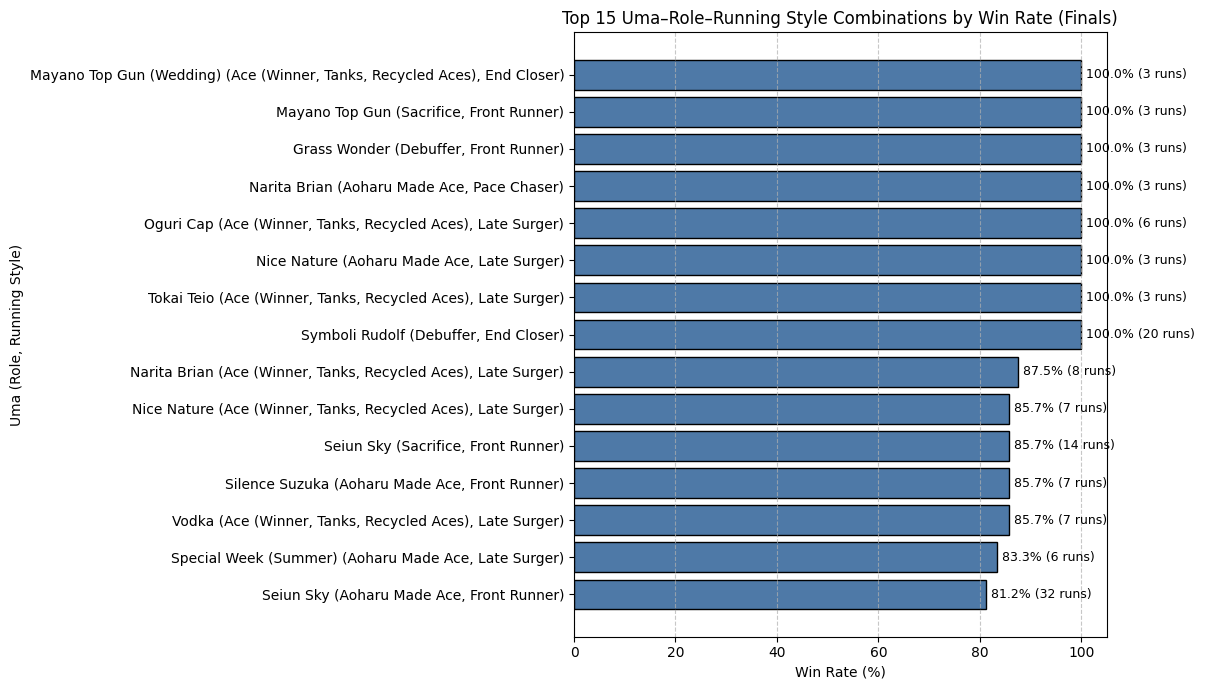

In [46]:
plt.figure(figsize=(12,7))
bars = plt.barh(
    [f"{uma} ({role}, {style})" for uma, role, style in top_combos.index],
    top_combos["Win Rate"],
    color="#4e79a7",
    edgecolor="black"
)

plt.title("Top 15 Uma–Role–Running Style Combinations by Win Rate (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Uma (Role, Running Style)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)

for i, (wr, total) in enumerate(zip(top_combos["Win Rate"], top_combos["Appearances"])):
    plt.text(wr + 1, i, f"{wr:.1f}% ({total} runs)", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [47]:
# Total number of appearances across all combos
total_appearances = combo_wr["Appearances"].sum()

# Add Meta Share (%) to the combo table
combo_wr["Meta Share"] = (combo_wr["Appearances"] / total_appearances * 100).round(2)

# Filter to reasonable samples (min 3 appearances)
meta_wr = combo_wr[combo_wr["Appearances"] >= 3].copy()

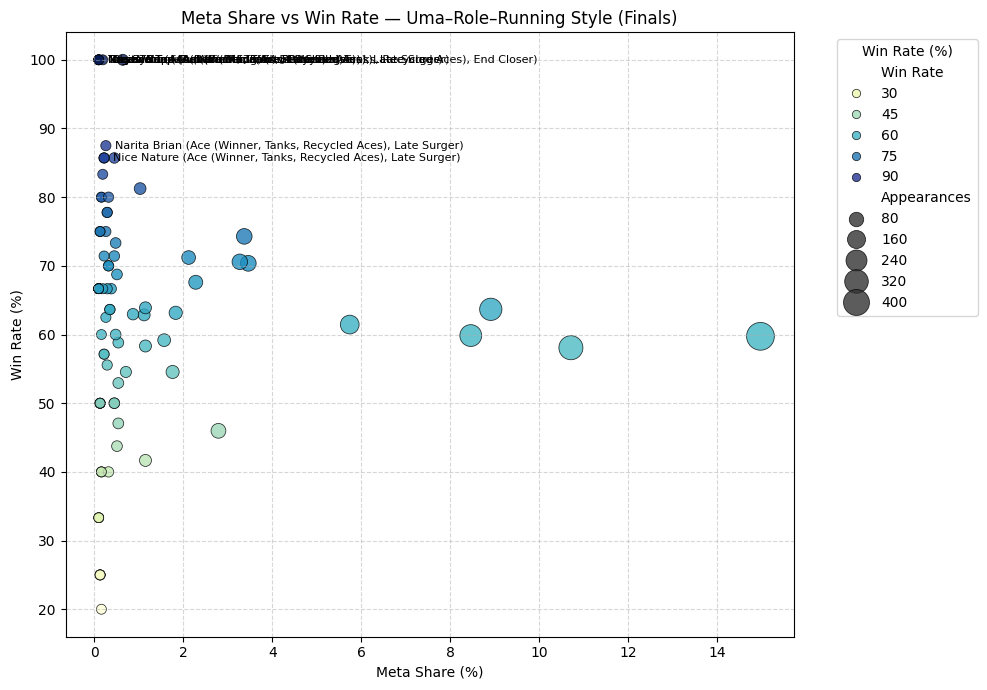

In [48]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=meta_wr,
    x="Meta Share",
    y="Win Rate",
    size="Appearances",
    hue="Win Rate",
    palette="YlGnBu",
    sizes=(50, 400),
    edgecolor="black",
    alpha=0.8
)

plt.title("Meta Share vs Win Rate — Uma–Role–Running Style (Finals)")
plt.xlabel("Meta Share (%)")
plt.ylabel("Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Win Rate (%)", bbox_to_anchor=(1.05, 1), loc="upper left")

# Annotate top performers
top_performers = meta_wr.sort_values("Win Rate", ascending=False).head(10)
for _, row in top_performers.iterrows():
    label = f"{row.name[0]} ({row.name[1]}, {row.name[2]})"
    plt.text(row["Meta Share"]+0.2, row["Win Rate"], label, fontsize=8, va='center')

plt.tight_layout()
plt.show()

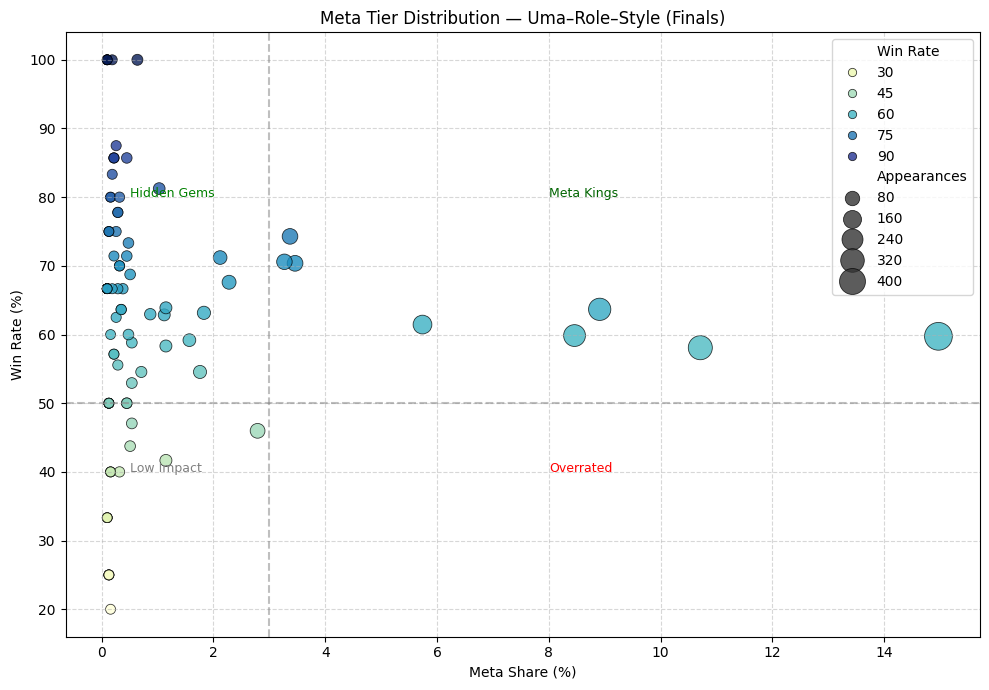

In [49]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=meta_wr,
    x="Meta Share",
    y="Win Rate",
    size="Appearances",
    hue="Win Rate",
    palette="YlGnBu",
    sizes=(50, 400),
    edgecolor="black",
    alpha=0.8
)

# Draw tier boundaries
plt.axhline(50, color="grey", linestyle="--", alpha=0.5)
plt.axvline(3, color="grey", linestyle="--", alpha=0.5)

plt.text(0.5, 80, "Hidden Gems", fontsize=9, color="green")
plt.text(8, 80, "Meta Kings", fontsize=9, color="darkgreen")
plt.text(8, 40, "Overrated", fontsize=9, color="red")
plt.text(0.5, 40, "Low Impact", fontsize=9, color="gray")

plt.title("Meta Tier Distribution — Uma–Role–Style (Finals)")
plt.xlabel("Meta Share (%)")
plt.ylabel("Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [50]:
# Aggregate: Uma–Role–Running Style
combo_wr = (
    role_style_df.groupby(["Uma", "Role", "Running Style"])["Win"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "Appearances", "sum": "Wins", "mean": "Win Rate"})
)

# Win Rate (%)
combo_wr["Win Rate"] = (combo_wr["Win Rate"] * 100).round(2)

# Meta Share (%) across all combos
total_appearances = combo_wr["Appearances"].sum()
combo_wr["Meta Share"] = (combo_wr["Appearances"] / total_appearances * 100).round(2)

# Filter tiny samples if desired (raise/lower this threshold as you like)
min_appearances = 3
leaderboard = combo_wr[combo_wr["Appearances"] >= min_appearances].copy()

# Sort primarily by Win Rate, secondarily by Appearances
leaderboard = leaderboard.sort_values(["Win Rate", "Appearances"], ascending=[False, False])

# Show the top 20
leaderboard_top20 = leaderboard.head(20)
leaderboard_top20


Appearances  \
Uma                      Role                               Running Style                
Symboli Rudolf           Debuffer                           End Closer              20   
Oguri Cap                Ace (Winner, Tanks, Recycled Aces) Late Surger              6   
Grass Wonder             Debuffer                           Front Runner             3   
Mayano Top Gun           Sacrifice                          Front Runner             3   
Mayano Top Gun (Wedding) Ace (Winner, Tanks, Recycled Aces) End Closer               3   
Narita Brian             Aoharu Made Ace                    Pace Chaser              3   
Nice Nature              Aoharu Made Ace                    Late Surger              3   
Tokai Teio               Ace (Winner, Tanks, Recycled Aces) Late Surger              3   
Narita Brian             Ace (Winner, Tanks, Recycled Aces) Late Surger              8   
Seiun Sky                Sacrifice                          Front Runner            14   
Nice Nature              Ace (Winner, Tanks, Recycled Aces) Late Surger              7   
Silence Suzuka           Aoharu Made Ace                    Front Runner             7   
Vodka                    Ace (Winner, Tanks, Recycled Aces) Late Surger              7   
Special Week (Summer)    Aoharu Made Ace                    Late Surger              6   
Seiun Sky                Aoharu Made Ace                    Front Runner            32   
Symboli Rudolf           Hybrid                             End Closer              10   
Nice Nature              Hybrid                             Late Surger              5   
Smart Falcon             Ace (Winner, Tanks, Recycled Aces) Front Runner             5   
Agnes Tachyon            Debuffer                           Pace Chaser              9   
Fuji Kiseki              Ace (Winner, Tanks, Recycled Aces) Pace Chaser              9   

                                                                           Wins  \
Uma                      Role                               Running Style         
Symboli Rudolf           Debuffer                           End Closer       20   
Oguri Cap                Ace (Winner, Tanks, Recycled Aces) Late Surger       6   
Grass Wonder             Debuffer                           Front Runner      3   
Mayano Top Gun           Sacrifice                          Front Runner      3   
Mayano Top Gun (Wedding) Ace (Winner, Tanks, Recycled Aces) End Closer        3   
Narita Brian             Aoharu Made Ace                    Pace Chaser       3   
Nice Nature              Aoharu Made Ace                    Late Surger       3   
Tokai Teio               Ace (Winner, Tanks, Recycled Aces) Late Surger       3   
Narita Brian             Ace (Winner, Tanks, Recycled Aces) Late Surger       7   
Seiun Sky                Sacrifice                          Front Runner     12   
Nice Nature              Ace (Winner, Tanks, Recycled Aces) Late Surger       6   
Silence Suzuka           Aoharu Made Ace                    Front Runner      6   
Vodka                    Ace (Winner, Tanks, Recycled Aces) Late Surger       6   
Special Week (Summer)    Aoharu Made Ace                    Late Surger       5   
Seiun Sky                Aoharu Made Ace                    Front Runner     26   
Symboli Rudolf           Hybrid                             End Closer        8   
Nice Nature              Hybrid                             Late Surger       4   
Smart Falcon             Ace (Winner, Tanks, Recycled Aces) Front Runner      4   
Agnes Tachyon            Debuffer                           Pace Chaser       7   
Fuji Kiseki              Ace (Winner, Tanks, Recycled Aces) Pace Chaser       7   

                                                                           Win Rate  \
Uma                      Role                               Running Style             
Symboli Rudolf           Debuffer                           End Closer       100.00   
Oguri 

In [51]:
leaderboard.to_excel("data/processed/uma_role_style_leaderboard.xlsx", index=True)
print("Saved: uma_role_style_leaderboard.xlsx")


Saved: uma_role_style_leaderboard.xlsx


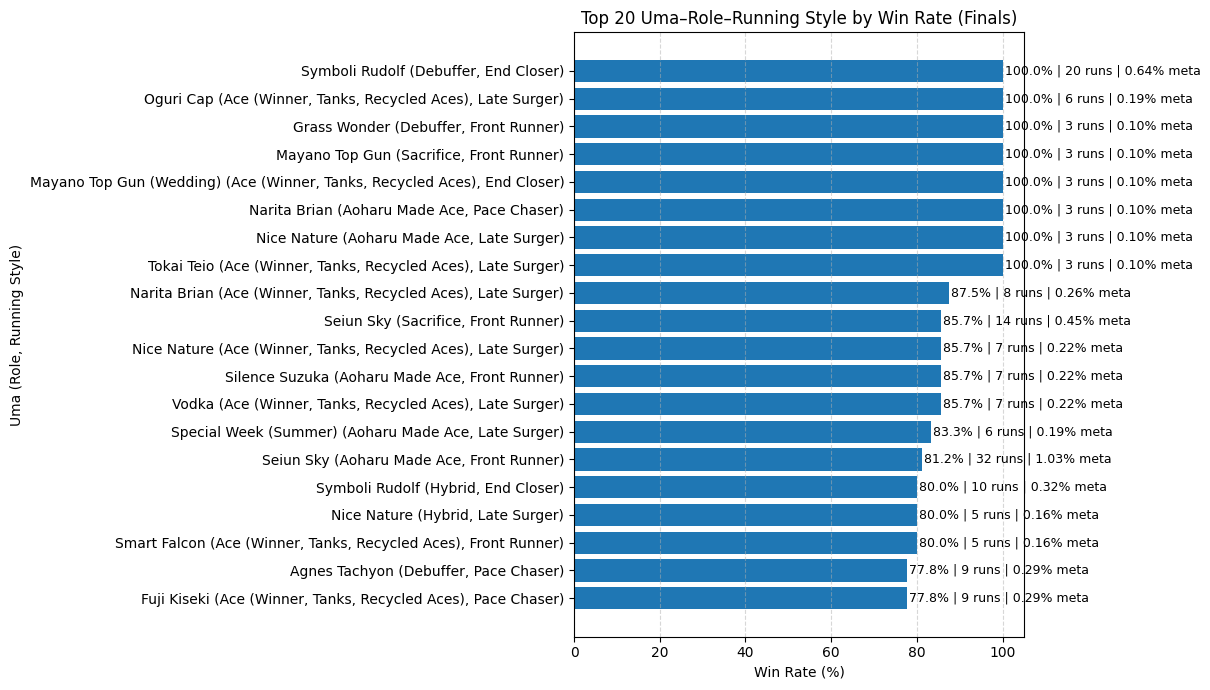

In [52]:
import matplotlib.pyplot as plt

topN = 20
plot_df = leaderboard.head(topN)

# Build friendly labels like: Gold Ship (Ace, End Closer)
labels = [f"{uma} ({role}, {style})" for uma, role, style in plot_df.index]

plt.figure(figsize=(12, 7))
plt.barh(labels, plot_df["Win Rate"])
plt.title(f"Top {topN} Uma–Role–Running Style by Win Rate (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Uma (Role, Running Style)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Annotate each bar with "XX.X% | N runs | Y.Y% meta"
for i, (wr, n, ms) in enumerate(zip(plot_df["Win Rate"], plot_df["Appearances"], plot_df["Meta Share"])):
    plt.text(wr + 0.5, i, f"{wr:.1f}% | {n} runs | {ms:.2f}% meta", va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [53]:
reliable = combo_wr[combo_wr["Appearances"] >= 10].sort_values("Win Rate", ascending=False).head(20)
reliable


Appearances  \
Uma                       Role                               Running Style                
Symboli Rudolf            Debuffer                           End Closer              20   
Seiun Sky                 Sacrifice                          Front Runner            14   
                          Aoharu Made Ace                    Front Runner            32   
Symboli Rudolf            Hybrid                             End Closer              10   
Maruzensky (Summer)       Aoharu Made Ace                    Front Runner           105   
Agnes Tachyon             Aoharu Made Ace                    Pace Chaser             15   
                          Hybrid                             Late Surger             14   
Grass Wonder              Debuffer                           End Closer              66   
Seiun Sky                 Ace (Winner, Tanks, Recycled Aces) Front Runner           102   
Oguri Cap                 Aoharu Made Ace                    Pace Chaser            108   
Mejiro Mcqueen            Ace (Winner, Tanks, Recycled Aces) Pace Chaser             10   
Tokai Teio (Anime Collab) Aoharu Made Ace                    Pace Chaser             10   
Mayano Top Gun            Ace (Winner, Tanks, Recycled Aces) Front Runner            16   
Gold Ship                 Aoharu Made Ace                    End Closer              71   
Meisho Doto               Aoharu Made Ace                    Pace Chaser             12   
Grass Wonder              Hybrid                             Late Surger             36   
Maruzensky (Summer)       Ace (Winner, Tanks, Recycled Aces) Front Runner           278   
Agnes Tachyon             Hybrid                             Pace Chaser             11   
Meisho Doto               Ace (Winner, Tanks, Recycled Aces) Late Surger             11   
Agnes Tachyon             Debuffer                           Late Surger             57   

                                                                            Wins  \
Uma                       Role                               Running Style         
Symboli Rudolf            Debuffer                           End Closer       20   
Seiun Sky                 Sacrifice                          Front Runner     12   
                          Aoharu Made Ace                    Front Runner     26   
Symboli Rudolf            Hybrid                             End Closer        8   
Maruzensky (Summer)       Aoharu Made Ace                    Front Runner     78   
Agnes Tachyon             Aoharu Made Ace                    Pace Chaser      11   
                          Hybrid                             Late Surger      10   
Grass Wonder              Debuffer                           End Closer       47   
Seiun Sky                 Ace (Winner, Tanks, Recycled Aces) Front Runner     72   
Oguri Cap                 Aoharu Made Ace                    Pace Chaser      76   
Mejiro Mcqueen            Ace (Winner, Tanks, Recycled Aces) Pace Chaser       7   
Tokai Teio (Anime Collab) Aoharu Made Ace                    Pace Chaser       7   
Mayano Top Gun            Ace (Winner, Tanks, Recycled Aces) Front Runner     11   
Gold Ship                 Aoharu Made Ace                    End Closer       48   
Meisho Doto               Aoharu Made Ace                    Pace Chaser       8   
Grass Wonder              Hybrid                             Late Surger      23   
Maruzensky (Summer)       Ace (Winner, Tanks, Recycled Aces) Front Runner    177   
Agnes Tachyon             Hybrid                             Pace Chaser       7   
Meisho Doto               Ace (Winner, Tanks, Recycled Aces) Late Surger       7   
Agnes Tachyon             Debuffer                           Late Surger      36   

                                                                            Win Rate  \
Uma                       Role                               Running Style             
Symboli Rudolf            Debuffer              

In [54]:
popular = leaderboard.sort_values("Meta Share", ascending=False).tail(20)
popular


Appearances  \
Uma                       Role                               Running Style                
Grass Wonder              Debuffer                           Front Runner             3   
Symboli Rudolf            Debuffer                           Front Runner             3   
Tokai Teio (Anime Collab) Troll Pick / Lazy                  Pace Chaser              3   
Nice Nature               Debuffer                           Front Runner             3   
Mayano Top Gun (Wedding)  Hybrid                             Late Surger              3   
Eishin Flash              Aoharu Made Ace                    Late Surger              3   
Fuji Kiseki               Aoharu Made Ace                    Pace Chaser              3   
El Condor Pasa            Ace (Winner, Tanks, Recycled Aces) Pace Chaser              3   
Grass Wonder              Debuffer                           Pace Chaser              3   
Mayano Top Gun            Ace (Winner, Tanks, Recycled Aces) Pace Chaser              3   
Mayano Top Gun (Wedding)  Ace (Winner, Tanks, Recycled Aces) Late Surger              3   
Gold Ship                 Ace (Winner, Tanks, Recycled Aces) Late Surger              3   
Narita Taishin            Aoharu Made Ace                    End Closer               3   
Mejiro Mcqueen            Aoharu Made Ace                    Front Runner             3   
Mihono Bourbon            Sacrifice                          Front Runner             3   
Mejiro Mcqueen            Aoharu Made Ace                    Pace Chaser              3   
Eishin Flash              Ace (Winner, Tanks, Recycled Aces) Late Surger              3   
Biwa Hayahide             Ace (Winner, Tanks, Recycled Aces) Pace Chaser              3   
Matikanefukukitaru        Ace (Winner, Tanks, Recycled Aces) Late Surger              3   
Rice Shower               Ace (Winner, Tanks, Recycled Aces) Late Surger              3   

                                                                            Wins  \
Uma                       Role                               Running Style         
Grass Wonder              Debuffer                           Front Runner      3   
Symboli Rudolf            Debuffer                           Front Runner      2   
Tokai Teio (Anime Collab) Troll Pick / Lazy                  Pace Chaser       2   
Nice Nature               Debuffer                           Front Runner      2   
Mayano Top Gun (Wedding)  Hybrid                             Late Surger       2   
Eishin Flash              Aoharu Made Ace                    Late Surger       2   
Fuji Kiseki               Aoharu Made Ace                    Pace Chaser       2   
El Condor Pasa            Ace (Winner, Tanks, Recycled Aces) Pace Chaser       2   
Grass Wonder              Debuffer                           Pace Chaser       2   
Mayano Top Gun            Ace (Winner, Tanks, Recycled Aces) Pace Chaser       2   
Mayano Top Gun (Wedding)  Ace (Winner, Tanks, Recycled Aces) Late Surger       2   
Gold Ship                 Ace (Winner, Tanks, Recycled Aces) Late Surger       2   
Narita Taishin            Aoharu Made Ace                    End Closer        2   
Mejiro Mcqueen            Aoharu Made Ace                    Front Runner      2   
Mihono Bourbon            Sacrifice                          Front Runner      2   
Mejiro Mcqueen            Aoharu Made Ace                    Pace Chaser       2   
Eishin Flash              Ace (Winner, Tanks, Recycled Aces) Late Surger       1   
Biwa Hayahide             Ace (Winner, Tanks, Recycled Aces) Pace Chaser       1   
Matikanefukukitaru        Ace (Winner, Tanks, Recycled Aces) Late Surger       1   
Rice Shower               Ace (Winner, Tanks, Recycled Aces) Late Surger       1   

                                                                            Win Rate  \
Uma                       Role                               Running Style             
Grass Wonder              Debuffer              

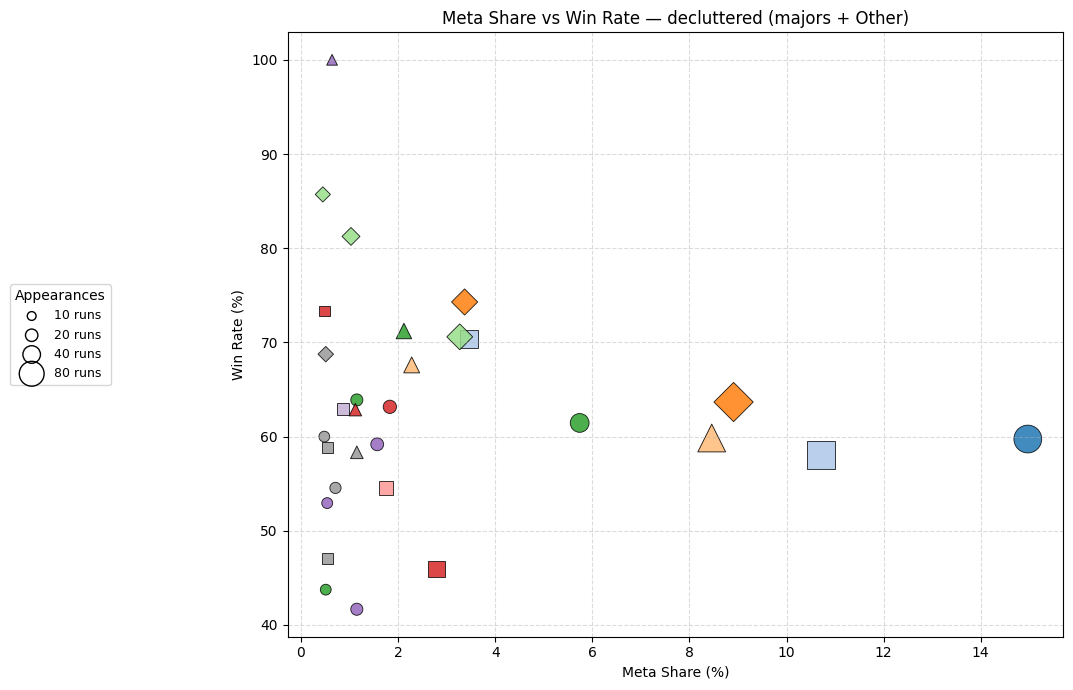

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plot_df = leaderboard.reset_index().copy()

# --- knobs ---
MIN_RUNS = 5          # hide tiny samples
TOP_UMAS = 10         # keep top N umas by appearances
TOP_ROWS = 30         # cap points shown (after filtering)

# filter by runs
plot_df = plot_df[plot_df["Appearances"] >= MIN_RUNS]

# collapse minor umas into "Other"
major = plot_df.groupby("Uma")["Appearances"].sum().sort_values(ascending=False).head(TOP_UMAS).index
plot_df["UmaCollapsed"] = plot_df["Uma"].where(plot_df["Uma"].isin(major), "Other")

# limit number of points (by meta share, then win rate)
plot_df = plot_df.sort_values(["Meta Share", "Win Rate"], ascending=[False, False]).head(TOP_ROWS)

# palette: distinct colors for majors, grey for Other
umas = plot_df["UmaCollapsed"].unique()
colors = sns.color_palette("tab20", n_colors=len(umas)-("Other" in umas))  # reserve grey for Other
palette = {u:c for u,c in zip([u for u in umas if u!="Other"], colors)}
palette["Other"] = (0.6, 0.6, 0.6)

# marker per running style (few shapes)
styles = plot_df["Running Style"].unique()
markers = ['o','s','D','^','v','P','X'][:len(styles)]
marker_map = dict(zip(styles, markers))

plt.figure(figsize=(11,7))
ax = plt.gca()

for style, m in marker_map.items():
    sub = plot_df[plot_df["Running Style"]==style]
    sns.scatterplot(
        data=sub, x="Meta Share", y="Win Rate",
        hue="UmaCollapsed", palette=palette,
        size="Appearances", sizes=(60, 400),
        edgecolor="black", alpha=0.85, marker=m, legend=False, ax=ax
    )

ax.set_title("Meta Share vs Win Rate — decluttered (majors + Other)")
ax.set_xlabel("Meta Share (%)"); ax.set_ylabel("Win Rate (%)")
ax.grid(True, linestyle="--", alpha=0.45)

# legends (compact)
uma_handles = [Patch(facecolor=palette[u], edgecolor='black', label=u) for u in sorted(umas, key=lambda x: (x=="Other", x))]
uma_legend = ax.legend(uma_handles, [h.get_label() for h in uma_handles],
    title="Uma (Collapsed)", bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(uma_legend)

style_handles = [Line2D([0],[0], marker=marker_map[s], color='w', label=s,
                        markerfacecolor='grey', markeredgecolor='black', markersize=8)
                 for s in marker_map]
style_legend = ax.legend(style_handles, [h.get_label() for h in style_handles],
    title="Running Style", bbox_to_anchor=(1.05, 0.08), loc="lower left", frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(style_legend)

size_labels = [10,20,40,80]
size_handles = [plt.scatter([],[], s=s*4, facecolors='none', edgecolors='black', label=f"{s} runs") for s in size_labels]
ax.legend(size_handles, [h.get_label() for h in size_handles],
    title="Appearances", bbox_to_anchor=(-0.22, 0.5), loc="center right", frameon=True, fontsize=9, title_fontsize=10)

plt.tight_layout(); plt.show()


In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# ========= 0) Load data if needed (edit path if you haven't already loaded df) =========
# df = pd.read_excel("/mnt/data/CM Data Collection - Leo Cup (Responses).xlsx")

# ========= 1) Build Finals subset & helpers (idempotent) =========
def build_finals(df):
    finals = df.copy()
    finals = finals.loc[:, ~finals.columns.str.contains('^Unnamed')]
    finals.columns = finals.columns.str.strip()

    # Filter "Finals" entries; your data uses "End Survey" for Finals
    finals = finals[finals['Select a round to fill data']
                    .astype(str).str.contains('End Survey', case=False, na=False)].copy()

    # Standardize
    finals['FINALS RESULTS'] = finals['FINALS RESULTS'].astype(str).str.strip().str.upper()
    if 'CM Group' in finals.columns:
        finals['CM Group'] = finals['CM Group'].astype(str).str.strip().str.title()

    # Binary win
    finals['Win'] = (finals['FINALS RESULTS'] == '1ST').astype(int)

    # Team Composition (normalized, order-insensitive)
    cols = [f"FINALS - Uma {i} Running Style" for i in (1,2,3) if f"FINALS - Uma {i} Running Style" in finals.columns]
    comp = finals[cols].copy()
    for c in comp.columns:
        comp[c] = comp[c].astype(str).replace('nan', np.nan).str.strip().str.title()

    def team_comp(row):
        parts = [p for p in row if pd.notna(p)]
        if not parts: return np.nan
        # shorten & normalize order
        short = [p.replace("Front Runner","Front").replace("Pace Chaser","Pace")
                   .replace("Late Surger","Late").replace("End Closer","End") for p in parts]
        return "-".join(sorted(short))

    finals['Team Composition'] = comp.apply(team_comp, axis=1)
    return finals

finals = build_finals(df)

# ========= 2) Team composition WR table =========
def build_wr_table(finals):
    wc = finals.dropna(subset=['Team Composition']).copy()
    wr = (wc.groupby('Team Composition')['Win']
            .agg(['count','sum','mean'])
            .rename(columns={'count':'Total Teams','sum':'Wins','mean':'Win Rate'}))
    wr['Win Rate'] = (wr['Win Rate'] * 100).round(2)
    wr = wr.sort_values(['Win Rate','Total Teams'], ascending=[False, False])
    return wr

wr_table = build_wr_table(finals)

# ========= 3) Uma & Role & Style tables =========
def build_uma_role_style(df):
    merged = []
    for i in (1,2,3):
        cols = [f"FINALS - Uma {i}", f"FINALS - Uma {i} Role", f"FINALS - Uma {i} Running Style", "FINALS RESULTS"]
        if all(c in df.columns for c in cols):
            tmp = df[cols].copy()
            tmp.columns = ["Uma","Role","Running Style","Result"]
            merged.append(tmp)
    rs = pd.concat(merged, ignore_index=True)

    rs = rs.dropna(subset=['Uma','Role','Running Style','Result']).copy()
    rs['Uma'] = rs['Uma'].astype(str).str.strip().str.title()
    rs['Role'] = rs['Role'].astype(str).str.strip().str.title()
    rs['Running Style'] = rs['Running Style'].astype(str).str.strip().str.title()
    rs['Result'] = rs['Result'].astype(str).str.upper().str.strip()
    rs['Win'] = (rs['Result'] == '1ST').astype(int)

    # Uma performance
    uma_wr = (rs.groupby('Uma')['Win']
                .agg(['count','sum','mean'])
                .rename(columns={'count':'Appearances','sum':'Wins','mean':'Win Rate'}))
    uma_wr['Win Rate'] = (uma_wr['Win Rate']*100).round(2)
    uma_wr = uma_wr.sort_values(['Win Rate','Appearances'], ascending=[False, False])

    # Role performance
    role_wr = (rs.groupby('Role')['Win']
                .agg(['count','sum','mean'])
                .rename(columns={'count':'Appearances','sum':'Wins','mean':'Win Rate'}))
    role_wr['Win Rate'] = (role_wr['Win Rate']*100).round(2)
    role_wr = role_wr.sort_values(['Win Rate','Appearances'], ascending=[False, False])

    # Role + Running Style performance
    role_style_wr = (rs.groupby(['Role','Running Style'])['Win']
                      .agg(['count','sum','mean'])
                      .rename(columns={'count':'Appearances','sum':'Wins','mean':'Win Rate'}))
    role_style_wr['Win Rate'] = (role_style_wr['Win Rate']*100).round(2)
    role_style_wr = role_style_wr.sort_values(['Win Rate','Appearances'], ascending=[False, False])

    # Uma + Role + Style combo (for meta)
    combo_wr = (rs.groupby(['Uma','Role','Running Style'])['Win']
                 .agg(['count','sum','mean'])
                 .rename(columns={'count':'Appearances','sum':'Wins','mean':'Win Rate'}))
    combo_wr['Win Rate'] = (combo_wr['Win Rate']*100).round(2)
    total_apps = combo_wr['Appearances'].sum()
    combo_wr['Meta Share'] = (combo_wr['Appearances']/total_apps*100).round(2)
    combo_wr = combo_wr.sort_values(['Win Rate','Meta Share'], ascending=[False, False])

    return rs, uma_wr, role_wr, role_style_wr, combo_wr

role_style_df, uma_wr, role_wr, role_style_wr, combo_wr = build_uma_role_style(df)

# Meta leaderboard (filter small samples)
leaderboard = combo_wr[combo_wr['Appearances'] >= 3].copy()

# ========= 4) Optional: Lobby WR summary if CM Group exists =========
def build_lobby_summary(finals):
    if 'CM Group' not in finals.columns:
        return pd.DataFrame()
    lobby = (finals.groupby('CM Group')['Win']
                .agg(['count','sum','mean'])
                .rename(columns={'count':'Players','sum':'Wins','mean':'Win Rate'}))
    lobby['Win Rate'] = (lobby['Win Rate']*100).round(2)
    lobby = lobby.sort_values('Win Rate', ascending=False)
    lobby.rename_axis('CM Group', inplace=True)
    return lobby

lobby_wr_summary = build_lobby_summary(finals)

# ========= 5) Build SUMMARY sheet content =========
def build_summary(finals, wr_table, uma_wr, role_wr, role_style_wr, combo_wr, lobby_wr_summary):
    total_players = len(finals)
    total_wins = finals['Win'].sum()
    overall_wr = (finals['Win'].mean()*100).round(2) if total_players else 0.0
    n_teams = finals['Team Composition'].notna().sum()
    n_unique_comps = finals['Team Composition'].nunique()
    n_umas = role_style_df['Uma'].nunique()
    n_roles = role_style_df['Role'].nunique()
    n_styles = role_style_df['Running Style'].nunique()

    kpis = pd.DataFrame({
        'Metric': [
            'Total Finals Entries',
            'Total Wins',
            'Overall Win Rate (%)',
            'Teams with Composition Data',
            'Unique Team Compositions',
            'Unique Umas',
            'Unique Roles',
            'Unique Running Styles',
        ],
        'Value': [
            total_players, total_wins, overall_wr,
            n_teams, n_unique_comps,
            n_umas, n_roles, n_styles
        ]
    })

    # Top lists (with minimum appearances for stability)
    MIN_APPS = 5
    top_comps = wr_table[wr_table['Total Teams']>=MIN_APPS].sort_values('Win Rate', ascending=False).head(10)
    top_umas = uma_wr[uma_wr['Appearances']>=MIN_APPS].sort_values('Win Rate', ascending=False).head(10)
    top_roles = role_wr.sort_values('Win Rate', ascending=False).head(10)
    top_role_style = role_style_wr[role_style_wr['Appearances']>=MIN_APPS].sort_values('Win Rate', ascending=False).head(10)
    top_combos = combo_wr[combo_wr['Appearances']>=MIN_APPS].sort_values('Win Rate', ascending=False).head(10)

    sections = {
        'KPIs': kpis,
        'Top Team Compositions (≥5)': top_comps,
        'Top Umas (≥5)': top_umas,
        'Top Roles': top_roles,
        'Top Role×Style (≥5)': top_role_style,
        'Top Uma×Role×Style (≥5)': top_combos
    }
    if not lobby_wr_summary.empty:
        sections['Lobby Win Rates'] = lobby_wr_summary

    return sections

summary_sections = build_summary(finals, wr_table, uma_wr, role_wr, role_style_wr, combo_wr, lobby_wr_summary)

# ========= 6) Write to Excel with multiple sheets =========
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
outfile = f"data/processed/UmaMusume_Analysis_Report_{timestamp}.xlsx"

with pd.ExcelWriter(outfile, engine="openpyxl") as writer:
    # Summary sheet: stack sections vertically
    row = 0
    for title, df_sec in summary_sections.items():
        # section title as a one-row DataFrame for clarity
        pd.DataFrame({title: []}).to_excel(writer, sheet_name="Summary", index=False, startrow=row)
        row += 1
        df_sec.to_excel(writer, sheet_name="Summary", index=True, startrow=row)
        row += len(df_sec) + 3  # gap

    # Full data sheets
    finals.to_excel(writer, sheet_name="Finals Raw Data", index=False)
    wr_table.to_excel(writer, sheet_name="Team Composition WR")
    uma_wr.to_excel(writer, sheet_name="Uma Performance")
    role_wr.to_excel(writer, sheet_name="Role Performance")
    role_style_wr.to_excel(writer, sheet_name="Role+Style WR")
    combo_wr.to_excel(writer, sheet_name="Uma-Role-Style WR")
    leaderboard.to_excel(writer, sheet_name="Meta Leaderboard")
    if not lobby_wr_summary.empty:
        lobby_wr_summary.to_excel(writer, sheet_name="Lobby WR Summary")

print(f"✅ Exported: {os.path.abspath(outfile)}")


✅ Exported: /workspaces/moomooleo/moomoo/data/processed/UmaMusume_Analysis_Report_20251117_0803.xlsx


In [57]:
import pandas as pd
import numpy as np

# Long table for Finals (works even if you later include other rounds)
long = []
for i in (1, 2, 3):
    cols = [
        f"FINALS - Uma {i}",
        f"FINALS - Uma {i} Role",
        f"FINALS - Uma {i} Running Style",
        "FINALS RESULTS",
        "Select a round to fill data",
        "Player IGN",
    ]
    if all(c in df.columns for c in cols):
        t = df[cols].copy()
        t.columns = ["Uma", "Role", "Running Style", "Result", "Round", "Player"]
        long.append(t)

entries = pd.concat(long, ignore_index=True)
entries = entries.dropna(subset=["Uma", "Role", "Running Style", "Result"]).copy()

# Clean
entries["Uma"] = entries["Uma"].str.strip().str.title()
entries["Role"] = entries["Role"].str.strip().str.title()
entries["Running Style"] = entries["Running Style"].str.strip().str.title()
entries["Result"] = entries["Result"].str.strip().str.upper()
entries["Round"] = entries["Round"].astype(str).str.strip().str.title()
entries["Win"] = (entries["Result"] == "1ST").astype(int)

# Finals-only helper if you prefer
entries_finals = entries[entries["Round"].str.contains("End Survey", na=False)].copy()


In [58]:
# Define what counts as "Debuffer"-like roles (tweak as needed)
DEBUFFER_PAT = r"Debuffer|Hybrid"   # catches 'Debuffer', 'Hybridor', etc.
ACE_PAT = r"Ace|Aoharu Made Ace"     # both "Ace (...)" and "Aoharu Made Ace"

# Uma WR (exclude debuffers)
uma_core = entries_finals[~entries_finals["Role"].str.contains(DEBUFFER_PAT, case=False, na=False)]
uma_wr_no_debuff = (uma_core.groupby("Uma")["Win"]
                      .agg(Appearances="count", Wins="sum", WinRate=lambda s: s.mean()*100)
                      .sort_values(["WinRate","Appearances"], ascending=[False, False])
                      .round({"WinRate":2}))

print(uma_wr_no_debuff.head(20))


                           Appearances  Wins  WinRate
Uma                                                  
Air Groove                           3     3   100.00
Air Groove (Wedding)                 1     1   100.00
Vodka                                9     8    88.89
Smart Falcon                         7     6    85.71
Nice Nature                         16    13    81.25
Mayano Top Gun (Wedding)            13    10    76.92
El Condor Pasa                       4     3    75.00
Winning Ticket                       4     3    75.00
Seiun Sky                          150   111    74.00
Narita Brian                        29    21    72.41
Fuji Kiseki                         14    10    71.43
Maruzensky                           7     5    71.43
Silence Suzuka                      17    12    70.59
Maruzensky (Summer)                384   256    66.67
Mejiro Mcqueen                      21    14    66.67
El Condor Pasa (Fantasy)             6     4    66.67
King Halo                   

In [59]:
# Build team lists per player row and normalize order
teams = df.copy()
teams = teams[teams["Select a round to fill data"].astype(str).str.contains("End Survey", na=False)].copy()

uma_cols = [f"FINALS - Uma {i}" for i in (1,2,3) if f"FINALS - Uma {i}" in teams.columns]
assert len(uma_cols) == 3, "Need Uma1/2/3 columns for Finals."

def clean_name(x):
    return str(x).strip().title() if pd.notna(x) else np.nan

for c in uma_cols:
    teams[c] = teams[c].apply(clean_name)

def trio_key(row):
    trio = [row[c] for c in uma_cols if pd.notna(row[c])]
    return " / ".join(sorted(trio)) if trio else np.nan

teams["Trio"] = teams.apply(trio_key, axis=1)
teams["Result"] = teams["FINALS RESULTS"].astype(str).str.upper().str.strip()
teams["Win"] = (teams["Result"] == "1ST").astype(int)

trio_wr = (teams.dropna(subset=["Trio"])
                .groupby("Trio")["Win"]
                .agg(Runs="count", Wins="sum", WinRate=lambda s: s.mean()*100)
                .round({"WinRate":2})
                .sort_values(["WinRate","Runs"], ascending=[False, False]))

print(trio_wr.head(20))


                                                    Runs  Wins  WinRate
Trio                                                                   
Grass Wonder / Maruzensky (Summer) / Seiun Sky        12    12    100.0
Agnes Tachyon / Maruzensky (Summer) / Seiun Sky        7     7    100.0
Agnes Tachyon / Grass Wonder / Maruzensky (Summer)     4     4    100.0
Agnes Tachyon / Maruzensky (Summer) / Mayano To...     3     3    100.0
Air Groove / Maruzensky (Summer) / Nice Nature         3     3    100.0
Gold Ship / Grass Wonder / Special Week (Summer)       3     3    100.0
Gold Ship / Nice Nature / Taiki Shuttle                3     3    100.0
Narita Brian / Nice Nature / Oguri Cap                 3     3    100.0
Agnes Tachyon / Grass Wonder / Meisho Doto             2     2    100.0
Agnes Tachyon / Oguri Cap / Special Week (Summer)      2     2    100.0
Daiwa Scarlet / Maruzensky (Summer) / Nice Nature      2     2    100.0
Gold Ship / Grass Wonder / Mejiro Mcqueen              2     2  

In [60]:
# Pull each team's 3 roles
role_cols = [f"FINALS - Uma {i} Role" for i in (1,2,3)]
ok = all(c in df.columns for c in role_cols)
assert ok, "Missing Finals role columns."

roles_df = teams[role_cols + ["Result"]].copy()
for c in role_cols:
    roles_df[c] = roles_df[c].astype(str).str.title()

def role_bucket(r):
    r = r or ""
    if pd.isna(r): return "Other"
    if "Debuffer" in r or "Hybrid" in r: return "Debuffer"
    if "Ace" in r: return "Ace"
    if "Hybrid" in r: return "Hybrid"
    return "Other"

for i, c in enumerate(role_cols, 1):
    roles_df[f"Role{i}B"] = roles_df[c].apply(role_bucket)

def role_archetype(row):
    counts = row[["Role1B","Role2B","Role3B"]].value_counts()
    n_ace = (row[["Role1B","Role2B","Role3B"]] == "Ace").sum()
    n_deb = (row[["Role1B","Role2B","Role3B"]] == "Debuffer").sum()
    n_hyb = (row[["Role1B","Role2B","Role3B"]] == "Hybrid").sum()
    n_oth = 3 - n_ace - n_deb - n_hyb
    label = []
    if n_ace: label.append(f"{n_ace} Ace")
    if n_deb: label.append(f"{n_deb} Debuffer")
    if n_hyb: label.append(f"{n_hyb} Hybrid")
    if n_oth: label.append(f"{n_oth} Other")
    return " + ".join(label)

roles_df["Archetype (Role Mix)"] = roles_df.apply(role_archetype, axis=1)
roles_df["Win"] = (roles_df["Result"].str.upper().str.strip() == "1ST").astype(int)

archetype_wr = (roles_df.groupby("Archetype (Role Mix)")["Win"]
                  .agg(Runs="count", Wins="sum", WinRate=lambda s: s.mean()*100)
                  .round({"WinRate":2})
                  .sort_values(["WinRate","Runs"], ascending=[False, False]))

print(archetype_wr.head(20))


                              Runs  Wins  WinRate
Archetype (Role Mix)                             
3 Ace                          171   112    65.50
1 Ace + 2 Debuffer             224   140    62.50
1 Ace + 1 Debuffer + 1 Other    31    19    61.29
2 Ace + 1 Debuffer             580   354    61.03
2 Ace + 1 Other                 23    14    60.87
3 Debuffer                       7     4    57.14
1 Ace + 2 Other                  4     2    50.00
3 Other                        450     0     0.00


In [61]:
style_cols = [f"FINALS - Uma {i} Running Style" for i in (1,2,3)]
styles_df = teams[style_cols + role_cols + ["Result"]].copy()

for c in style_cols:
    styles_df[c] = styles_df[c].astype(str).str.title()

for c in role_cols:
    styles_df[c] = styles_df[c].astype(str).str.title()

def style_short(s):
    return (s.replace("Front Runner","Front")
             .replace("Pace Chaser","Pace")
             .replace("Late Surger","Late")
             .replace("End Closer","End"))

for c in style_cols:
    styles_df[c] = styles_df[c].apply(style_short)

def has_debuffer(row):
    vals = [row[c] for c in role_cols]
    return any(("Debuffer" in str(v)) or ("Hybrid" in str(v)) for v in vals)

def style_mix_label(row):
    styles = [row[c] for c in style_cols if pd.notna(row[c])]
    counts = pd.Series(styles).value_counts()
    parts = []
    for k in ["Front","Pace","Late","End"]:
        n = int(counts.get(k, 0))
        if n == 2: parts.append(f"Double {k}")
        elif n == 3: parts.append(f"Triple {k}")
        elif n == 1: parts.append(f"{k}")
    if has_debuffer(row):
        parts.append("+ Debuffer")
    return " ".join(parts) if parts else "Did Not Submit"

styles_df["Style Archetype"] = styles_df.apply(style_mix_label, axis=1)
styles_df["Win"] = (styles_df["Result"].str.upper().str.strip() == "1ST").astype(int)

style_arch_wr = (styles_df.groupby("Style Archetype")["Win"]
                   .agg(Runs="count", Wins="sum", WinRate=lambda s: s.mean()*100)
                   .round({"WinRate":2})
                   .sort_values(["WinRate","Runs"], ascending=[False, False]))

print(style_arch_wr.head(20))


                              Runs  Wins  WinRate
Style Archetype                                  
Pace Double Late                 4     4   100.00
Front Double End                 1     1   100.00
Double Front End + Debuffer      9     8    88.89
Triple End + Debuffer            6     5    83.33
Triple Front                    10     8    80.00
Double Front Late                5     4    80.00
Front Double Pace + Debuffer     5     4    80.00
Double Front Late + Debuffer    77    58    75.32
Double Front Pace               56    42    75.00
Front Late End                   8     6    75.00
Double Pace End + Debuffer       4     3    75.00
Front Double Late                4     3    75.00
Double Pace Late                 7     5    71.43
Front Double End + Debuffer      7     5    71.43
Late Double End + Debuffer      17    12    70.59
Pace Double End + Debuffer      45    31    68.89
Triple Late + Debuffer          12     8    66.67
Triple Front + Debuffer          3     2    66.67


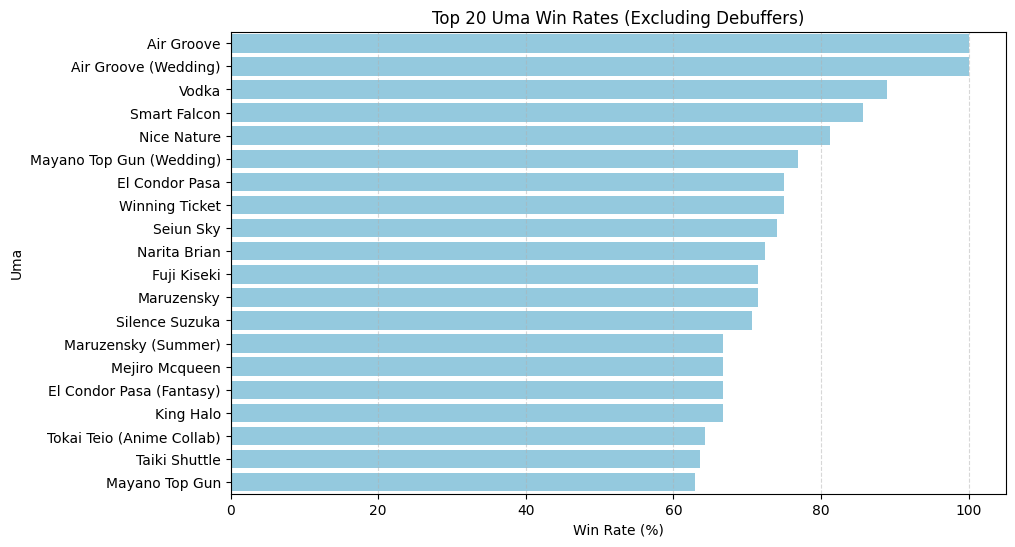

In [62]:
plt.figure(figsize=(10,6))
top_umas = uma_wr_no_debuff.head(20).sort_values("WinRate", ascending=False)
sns.barplot(data=top_umas, y=top_umas.index, x="WinRate", color="skyblue")
plt.title("Top 20 Uma Win Rates (Excluding Debuffers)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Uma")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


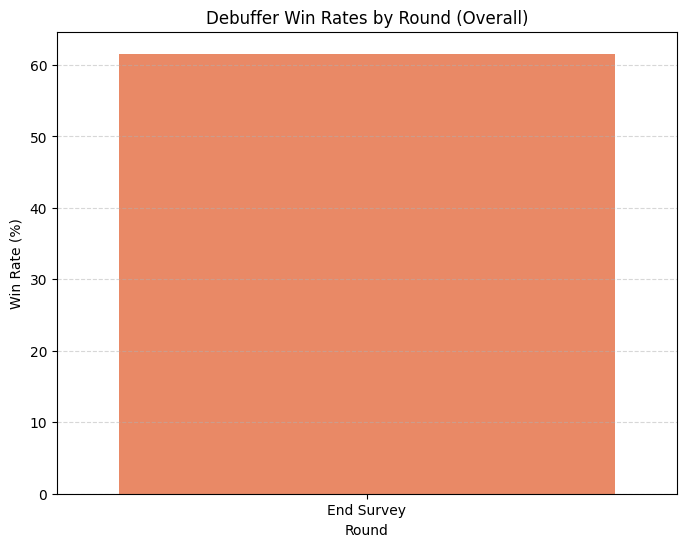

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only debuffers
DEBUFFER_PAT = r"Debuffer|Hybrid"

deb = entries_finals[entries_finals["Role"].str.contains(DEBUFFER_PAT, case=False, na=False)].copy()

# Compute WR by round (if you only have Finals, you’ll get one bar)
deb_by_round_simple = (
    deb.groupby("Round")["Win"]
    .agg(Runs="count", Wins="sum", WinRate=lambda s: s.mean() * 100)
    .round({"WinRate": 2})
    .sort_values("WinRate", ascending=False)
)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=deb_by_round_simple.reset_index(),
    x="Round", y="WinRate", color="coral"
)
plt.title("Debuffer Win Rates by Round (Overall)")
plt.ylabel("Win Rate (%)")
plt.xlabel("Round")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


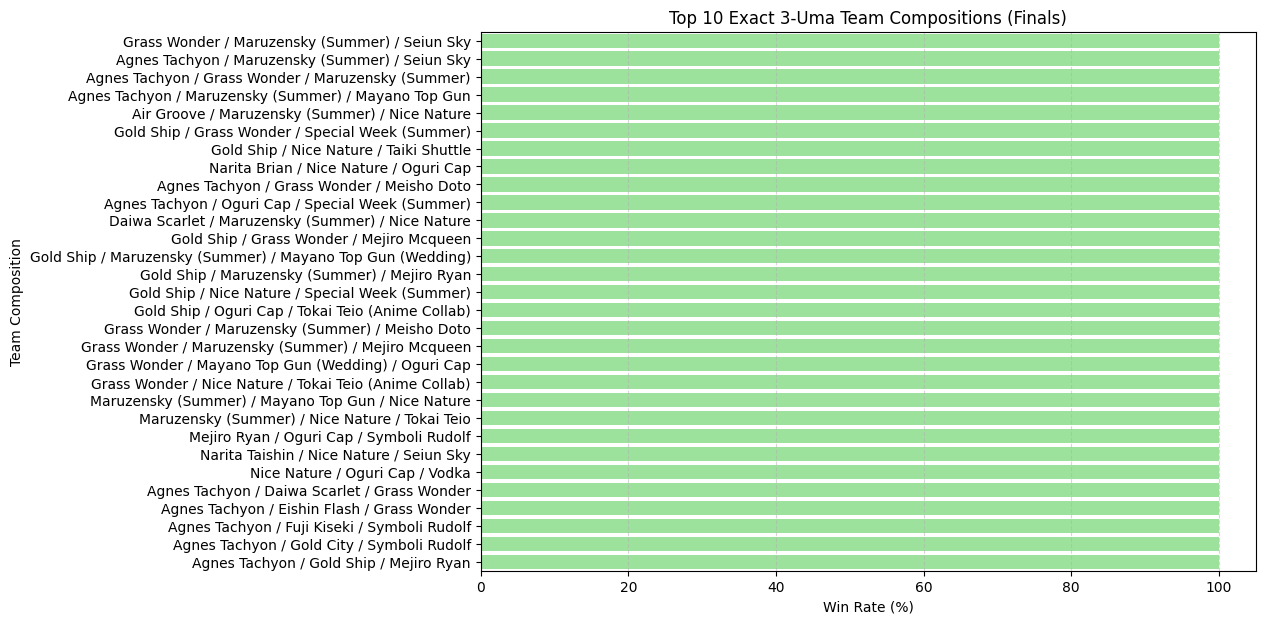

In [64]:
plt.figure(figsize=(10,7))
top_trios = trio_wr.head(30).sort_values("WinRate", ascending=True)
sns.barplot(data=top_trios, y=top_trios.index, x="WinRate", color="lightgreen")
plt.title("Top 10 Exact 3-Uma Team Compositions (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Team Composition")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()



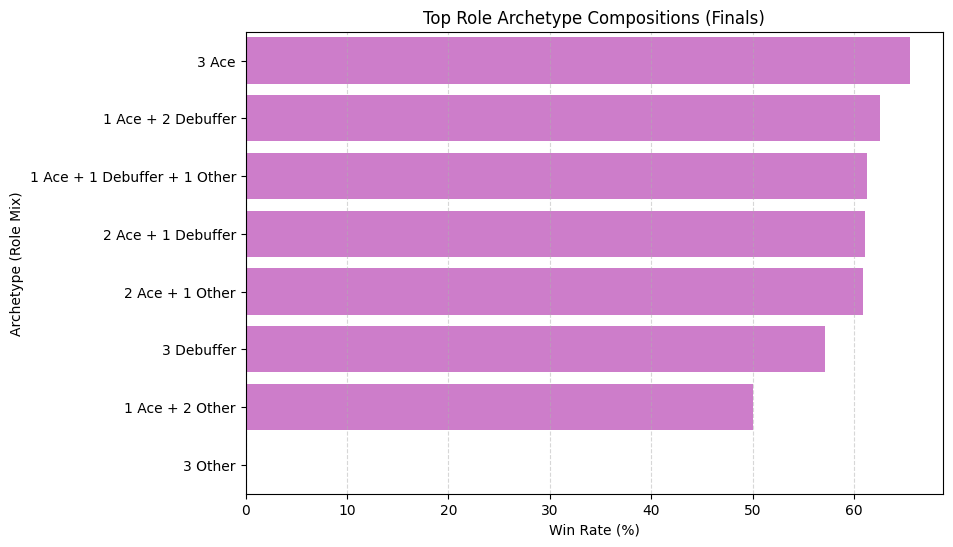

In [65]:
plt.figure(figsize=(9,6))
top_arch = archetype_wr.sort_values("WinRate", ascending=False).head(10)
sns.barplot(data=top_arch, y=top_arch.index, x="WinRate", color="orchid")
plt.title("Top Role Archetype Compositions (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Archetype (Role Mix)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


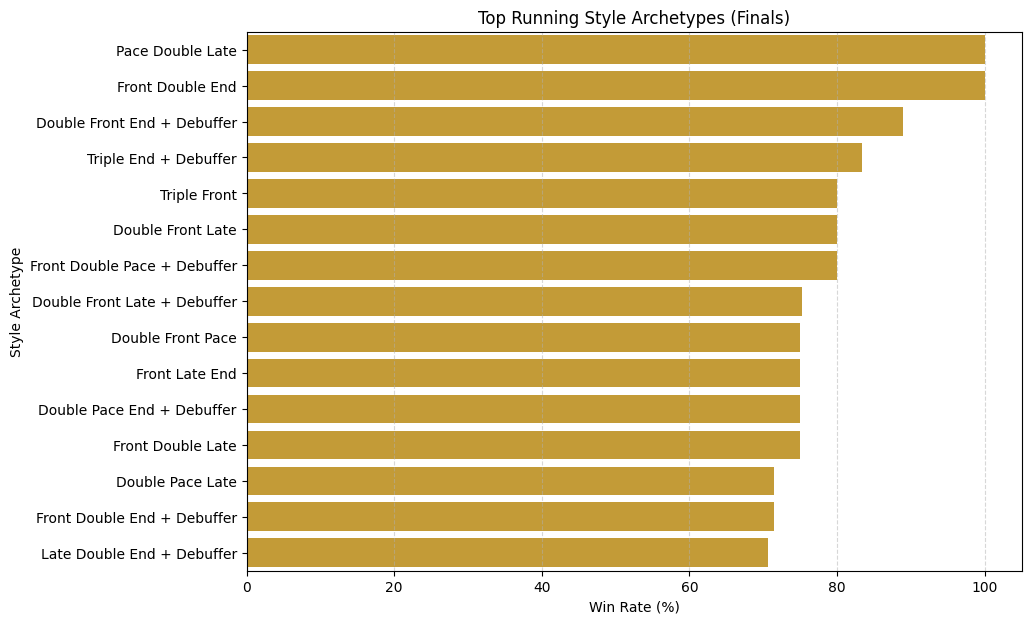

In [66]:
plt.figure(figsize=(10,7))
top_styles = style_arch_wr.head(15).sort_values("WinRate", ascending=False)
sns.barplot(data=top_styles, y=top_styles.index, x="WinRate", color="goldenrod")
plt.title("Top Running Style Archetypes (Finals)")
plt.xlabel("Win Rate (%)")
plt.ylabel("Style Archetype")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


In [67]:
import pandas as pd
from datetime import datetime
import os

# --- Compute key stats for the summary sheet ---
summary_data = {
    "Metric": [
        "Total Umas (No Debuffers)",
        "Average Uma Win Rate (%)",
        "Top Uma (by Win Rate)",
        "Top Role Archetype",
        "Top Style Archetype",
    ],
    "Value": [
        len(uma_wr_no_debuff),
        round(uma_wr_no_debuff["WinRate"].mean(), 2),
        uma_wr_no_debuff["WinRate"].idxmax() if not uma_wr_no_debuff.empty else "N/A",
        archetype_wr["WinRate"].idxmax() if not archetype_wr.empty else "N/A",
        style_arch_wr["WinRate"].idxmax() if not style_arch_wr.empty else "N/A",
    ],
}

summary_df = pd.DataFrame(summary_data)
summary_df["Notes"] = [
    "",
    "Across all Umas excluding Debuffers",
    "Highest performer among Aces/Hybrids",
    "Most successful Role composition",
    "Most successful Style archetype",
]


In [68]:
# Timestamped filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
outfile = f"data/processed/Uma_WR_Archetypes_Summary_{timestamp}.xlsx"

# Write to Excel
with pd.ExcelWriter(outfile, engine="openpyxl") as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    uma_wr_no_debuff.to_excel(writer, sheet_name="Uma WR (No Debuffers)")
    archetype_wr.to_excel(writer, sheet_name="Role Archetypes")
    style_arch_wr.to_excel(writer, sheet_name="Style Archetypes")

print(f"✅ Exported to: {os.path.abspath(outfile)}")


✅ Exported to: /workspaces/moomooleo/moomoo/data/processed/Uma_WR_Archetypes_Summary_20251117_0804.xlsx


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.drawing.image import Image

# Plot a few visuals and save as images
def save_chart(df, title, filename, color="skyblue", top=10):
    plt.figure(figsize=(9,6))
    sns.barplot(data=df.head(top).sort_values("WinRate", ascending=True),
                y=df.head(top).index, x="WinRate", color=color)
    plt.title(title)
    plt.xlabel("Win Rate (%)")
    plt.ylabel("")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.close()

save_chart(uma_wr_no_debuff, "Top Uma WR (No Debuffers)", "chart_uma.png")
save_chart(archetype_wr, "Top Role Archetypes", "chart_role.png", color="orchid")
save_chart(style_arch_wr, "Top Style Archetypes", "chart_style.png", color="goldenrod")

# Insert them into Excel
wb = load_workbook(outfile)
ws = wb.create_sheet("Charts")

for i, img_file in enumerate(["chart_uma.png", "chart_role.png", "chart_style.png"], start=1):
    img = Image(img_file)
    img.anchor = f"A{(i-1)*25 + 1}"  # space charts vertically
    ws.add_image(img)

wb.save(outfile)
print(f"✅ Charts added to Excel: {os.path.abspath(outfile)}")


✅ Charts added to Excel: /workspaces/moomooleo/moomoo/data/processed/Uma_WR_Archetypes_Summary_20251117_0804.xlsx


In [70]:
# --- columns used for archetypes ---
role_cols  = [f"FINALS - Uma {i} Role" for i in (1,2,3)]
style_cols = [f"FINALS - Uma {i} Running Style" for i in (1,2,3)]

# Work on Finals rows only
mask_finals = df["Select a round to fill data"].astype(str).str.contains("End Survey", na=False)
teams = df.loc[mask_finals, role_cols + style_cols + ["Player IGN","FINALS RESULTS"]].copy()

# Quick cleanliness checks
missing_any_role  = teams[role_cols].isna().any(axis=1).sum()
missing_any_style = teams[style_cols].isna().any(axis=1).sum()
print("Rows missing at least one ROLE:", missing_any_role)
print("Rows missing at least one STYLE:", missing_any_style)

# See the raw unique strings that may be breaking your regex/buckets
for c in role_cols:
    print(f"\nTop raw role tokens in {c}:")
    print(teams[c].value_counts(dropna=False).head(20))

for c in style_cols:
    print(f"\nTop raw style tokens in {c}:")
    print(teams[c].value_counts(dropna=False).head(20))

Rows missing at least one ROLE: 450
Rows missing at least one STYLE: 450

Top raw role tokens in FINALS - Uma 1 Role:
FINALS - Uma 1 Role
Ace (Winner, Tanks, Recycled Aces)    753
NaN                                   450
Aoharu Made Ace                       243
Debuffer                               21
Hybrid                                 20
Sacrifice                               2
Troll Pick / Lazy                       1
Name: count, dtype: int64

Top raw role tokens in FINALS - Uma 2 Role:
FINALS - Uma 2 Role
Ace (Winner, Tanks, Recycled Aces)    587
NaN                                   450
Debuffer                              178
Aoharu Made Ace                       149
Hybrid                                 93
Sacrifice                              19
Troll Pick / Lazy                      10
Blocker                                 4
Name: count, dtype: int64

Top raw role tokens in FINALS - Uma 3 Role:
FINALS - Uma 3 Role
Debuffer                              715
NaN     

In [71]:
# Assuming you want to plot Uma-level data
df_meta = uma_wr_no_debuff.copy()

# Compute Meta Share (%) = proportion of total runs
total_runs = df_meta["Appearances"].sum()
df_meta["Meta Share"] = (df_meta["Appearances"] / total_runs * 100).round(2)

df_meta.head()

Appearances  Wins  WinRate  Meta Share
Uma                                                         
Air Groove                      3     3   100.00        0.15
Air Groove (Wedding)            1     1   100.00        0.05
Vodka                           9     8    88.89        0.44
Smart Falcon                    7     6    85.71        0.34
Nice Nature                    16    13    81.25        0.78

In [72]:
import seaborn as sns

# 1) Build a stable color map by Uma (once, before plotting)
def make_color_map(names):
    # Any-length palette; "hls" gives distinct hues beyond 20 entries
    palette = sns.color_palette("hls", len(names))
    return dict(zip(names, palette))

# After you create df (with columns: Uma, Appearances, WinRate, Meta Share):
umas = sorted(uma_wr_no_debuff.reset_index()["Uma"].unique())
COLOR_MAP = make_color_map(umas)

# Use this everywhere:
# df["Color"] = df["Uma"].map(COLOR_MAP)


In [73]:
import matplotlib.patheffects as pe

def label_top_n(ax, df, top_labels=10, color_map=None, split_x=None):
    """
    Places labels for the top N most-used Umas with consistent, screen-space offsets.
    - Offsets are in 'points' so they don't blow up when axis limits change.
    - Auto-flips to the left if the bubble is on the right half of the plot.
    """
    top_used = df.nlargest(top_labels, "Appearances").copy()

    x_left, x_right = ax.get_xlim()
    x_mid = split_x if split_x is not None else (x_left + x_right) / 2.0

    texts = []
    for _, r in top_used.iterrows():
        x, y = float(r["Meta Share"]), float(r["WinRate"])
        # If the point is to the right of the split (or mid), nudge left; else nudge right
        if x > x_mid:
            xytext = (-8, 0)      # 8 points to the LEFT
            ha = "right"
        else:
            xytext = (8, 0)       # 8 points to the RIGHT
            ha = "left"

        t = ax.annotate(
            r["Uma"],
            xy=(x, y),
            xytext=xytext,
            textcoords="offset points",   # << key: fixed in screen space
            ha=ha, va="center",
            fontsize=10, fontweight="bold",
            color=(color_map[r["Uma"]] if color_map else "black"),
            path_effects=[pe.withStroke(linewidth=2, foreground="white")],  # readable on dots
            arrowprops=dict(arrowstyle="-", lw=0.6, color="dimgray", alpha=0.8)
        )
        texts.append(t)

    # Optional: tiny nudge pass if adjustText is available
    try:
        from adjustText import adjust_text
        adjust_text(
            texts, ax=ax,
            only_move={"points":"y", "text":"xy"},
            expand_points=(1.1,1.1), expand_text=(1.02,1.05),
            arrowprops=dict(arrowstyle="-", lw=0.6, color="dimgray", alpha=0.8)
        )
    except Exception:
        pass


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

def plot_bubble_meta_wr_all(uma_wr_no_debuff, roundTitle, top_labels=10):
    """
    Meta Share vs Win Rate — full data bubble chart (no trimming).
    - Huge markers preserved (size ~ Appearances).
    - Labels only top-N most-used Umas with screen-space offsets (consistent & readable).
    - Vertical dashed line = where cumulative Appearances reach 50% of total.
    """

    # ---------- Prep data ----------
    df = uma_wr_no_debuff.copy().reset_index()
    total_apps = df["Appearances"].sum()
    if total_apps == 0:
        raise ValueError("No appearances found.")
    df["Meta Share"] = df["Appearances"] / total_apps * 100

    # Stable color map by Uma (avoids palette/ordering drift)
    umas = sorted(df["Uma"].unique())
    palette = sns.color_palette("hls", len(umas))  # many distinct hues safely
    COLOR_MAP = dict(zip(umas, palette))
    df["Color"] = df["Uma"].map(COLOR_MAP)

    # Cumulative 50% (by Appearances)
    df_sorted = df.sort_values("Meta Share", ascending=False).reset_index(drop=True)
    df_sorted["Cum Appearances"] = df_sorted["Appearances"].cumsum()
    df_sorted["Cum Share (%)"] = df_sorted["Cum Appearances"] / total_apps * 100
    split_x = df_sorted.loc[df_sorted["Cum Share (%)"] >= 50, "Meta Share"].iloc[0]

    wr_baseline = df["WinRate"].mean()

    # ---------- Figure size (auto-scale) ----------
    n = len(df)
    base_w, base_h = 14, 7
    fig_w = base_w + min(12, n / 20)
    fig_h = base_h + min(8,  n / 25)
    plt.figure(figsize=(fig_w, fig_h))
    ax = plt.gca()

    # ---------- Scatter + shading ----------
    # Set limits FIRST so later annotations can use y-limits reliably
    x_max = df["Meta Share"].max() * 1.05
    y_max = min(100, df["WinRate"].max() * 1.10)
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)

    # Regions and reference lines
    ax.axvspan(0, split_x, facecolor="gray", alpha=0.05, zorder=0)
    ax.axvspan(split_x, x_max, facecolor="purple", alpha=0.06, zorder=0)
    ax.axvline(split_x, color="purple", linestyle="--", linewidth=1.6, alpha=0.9, zorder=1)
    ax.axhline(wr_baseline, color="gray", linestyle="--", linewidth=1.0, alpha=0.7, zorder=1)

    # Full-size bubbles (huge markers preserved)
    ax.scatter(
        df["Meta Share"], df["WinRate"],
        s=df["Appearances"] * 4,    # <- keep it big
        c=df["Uma"].map(COLOR_MAP),
        edgecolor="black", linewidth=0.7, alpha=0.9, zorder=2
    )

    # ---------- Label top-N most-used with screen-space offsets ----------
    def label_top_n(ax, df_top, color_map, pivot_x):
        # Use screen-space offset in POINTS; flip to left if on right side of pivot
        for _, r in df_top.iterrows():
            x, y = float(r["Meta Share"]), float(r["WinRate"])
            flip_left = x > pivot_x
            xytext = (-10, 0) if flip_left else (10, 0)
            ha = "right" if flip_left else "left"
            ax.annotate(
                r["Uma"],
                xy=(x, y),
                xytext=xytext,
                textcoords="offset points",   # <-- stable regardless of axis scale
                ha=ha, va="center",
                fontsize=10, fontweight="bold",
                color=color_map[r["Uma"]],
                path_effects=[pe.withStroke(linewidth=2, foreground="white")],
                arrowprops=dict(arrowstyle="-", lw=0.6, color="dimgray", alpha=0.8)
            )

    top_used = df.nlargest(top_labels, "Appearances")
    label_top_n(ax, top_used, COLOR_MAP, pivot_x=split_x)

    # ---------- Legend ----------
    handles = [
        plt.Line2D([0],[0], marker='o', color='w',
                   markerfacecolor=COLOR_MAP[row["Uma"]], markeredgecolor="black",
                   markersize=8, label=f"{row['Uma']} ({int(row['Appearances'])})")
        for _, row in df.sort_values("Meta Share", ascending=False).iterrows()
    ]
    ax.legend(handles=handles, title="Umas (Appearances)",
              bbox_to_anchor=(1.02, 1), loc="upper left",
              fontsize=8, title_fontsize=10)

    # ---------- Cosmetics ----------
    ax.set_title(roundTitle,
                 fontsize=16, pad=14)
    ax.set_xlabel("Meta Share (%)", fontsize=12)
    ax.set_ylabel("Win Rate (%)", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.4)

    # Place the 50% label AFTER limits so it sticks to the top edge
    ax.text(split_x + (x_max * 0.005), ax.get_ylim()[1] * 0.98,
            "50% of Total Appearances", color="purple",
            fontsize=10, rotation=90, va="top")

    ax.text(0.5, wr_baseline + 1.0, "Average Win Rate", color="gray", fontsize=10)

    plt.tight_layout(rect=[0,0,0.82,1])
    plt.show()


    df["Score"] = (
    df["WinRate"].rank(pct=True) +
    df["Meta Share"].rank(pct=True)
    )
    top_meta_wr = df.sort_values("Score", ascending=False).head(10)
    print(top_meta_wr[["Uma", "WinRate", "Meta Share", "Appearances"]])

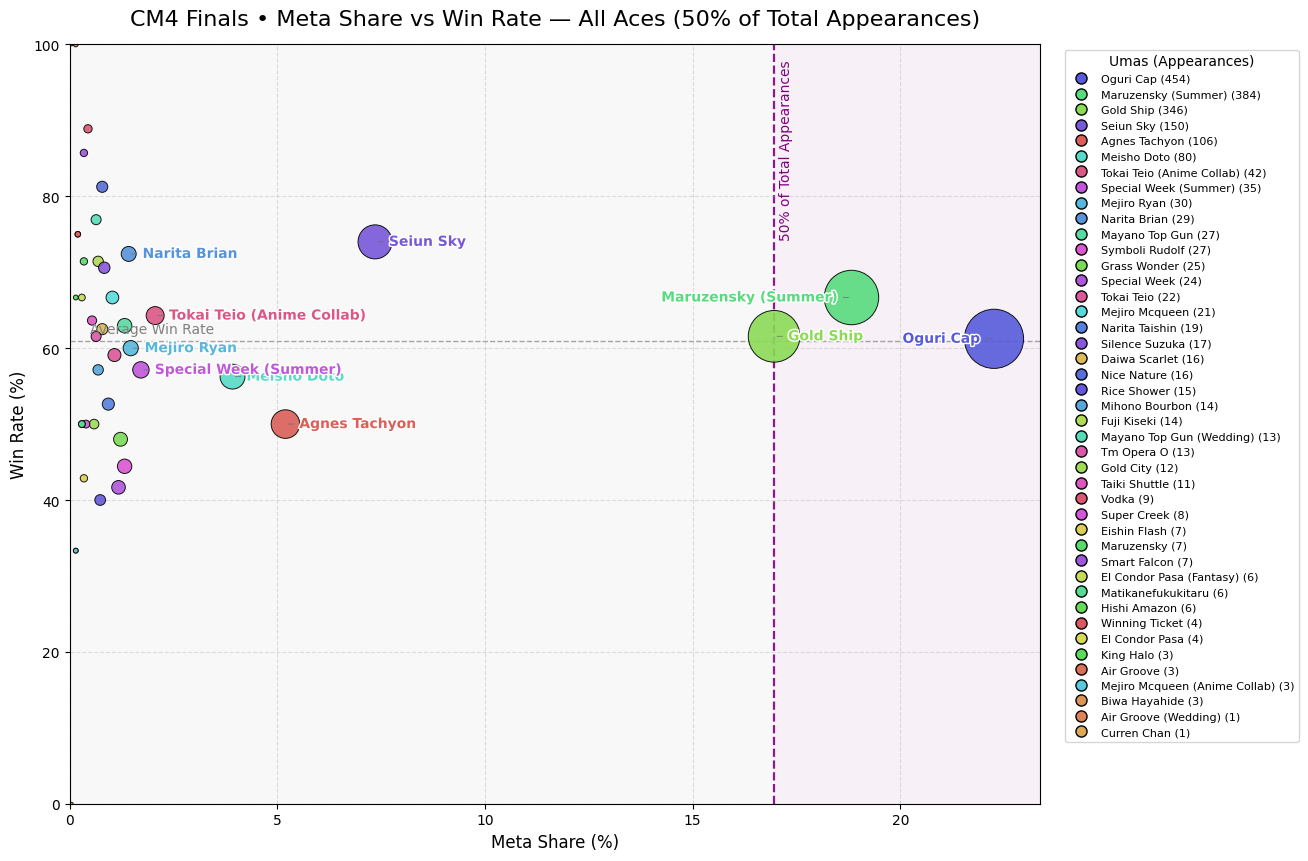

                          Uma  WinRate  Meta Share  Appearances
8                   Seiun Sky    74.00    7.352941          150
13        Maruzensky (Summer)    66.67   18.823529          384
9                Narita Brian    72.41    1.421569           29
4                 Nice Nature    81.25    0.784314           16
21                  Gold Ship    61.56   16.960784          346
17  Tokai Teio (Anime Collab)    64.29    2.058824           42
23                  Oguri Cap    61.23   22.254902          454
5    Mayano Top Gun (Wedding)    76.92    0.637255           13
2                       Vodka    88.89    0.441176            9
12             Silence Suzuka    70.59    0.833333           17


In [75]:
plot_bubble_meta_wr_all(uma_wr_no_debuff,"CM4 Finals • Meta Share vs Win Rate — All Aces (50% of Total Appearances)", top_labels=10)

In [76]:
print(uma_wr_no_debuff)


                               Appearances  Wins  WinRate
Uma                                                      
Air Groove                               3     3   100.00
Air Groove (Wedding)                     1     1   100.00
Vodka                                    9     8    88.89
Smart Falcon                             7     6    85.71
Nice Nature                             16    13    81.25
Mayano Top Gun (Wedding)                13    10    76.92
El Condor Pasa                           4     3    75.00
Winning Ticket                           4     3    75.00
Seiun Sky                              150   111    74.00
Narita Brian                            29    21    72.41
Fuji Kiseki                             14    10    71.43
Maruzensky                               7     5    71.43
Silence Suzuka                          17    12    70.59
Maruzensky (Summer)                    384   256    66.67
Mejiro Mcqueen                          21    14    66.67
El Condor Pasa

In [77]:
def normalize_role(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().lower()
    # Treat Hybrid as Debuffer (your request)
    if "debuffer" in s or "hybrid" in s or "domin" in s:
        return "Debuffer"
    if "aoharu made ace" in s or "ace" in s:
        return "Ace"
    return "Other"

def normalize_style(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().lower()
    if "front" in s: return "Front Runner"
    if "pace"  in s: return "Pace Chaser"
    if "late"  in s: return "Late Surger"
    if "end"   in s: return "End Closer"
    return pd.NA  # leave truly unknown as NA (better than "Unknown")

In [78]:

# (flattened like R1D1/R2D1 versions)

# Just in case, let's rebuild it cleanly:
finals_cols = [
    "FINALS - Uma 1", "FINALS - Uma 1 Role", "FINALS - Uma 1 Running Style",
    "FINALS - Uma 2", "FINALS - Uma 2 Role", "FINALS - Uma 2 Running Style",
    "FINALS - Uma 3", "FINALS - Uma 3 Role", "FINALS - Uma 3 Running Style",
    "FINALS RESULTS",
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)",
    "CM Group"
]

finals_df = df[[c for c in finals_cols if c in df.columns]].copy()
rows = []

for i in [1, 2, 3]:
    uma_col = f"FINALS - Uma {i}"
    role_col = f"FINALS - Uma {i} Role"
    style_col = f"FINALS - Uma {i} Running Style"
    result_col = "FINALS RESULTS"

    if uma_col not in finals_df.columns:
        continue

    temp = finals_df[[c for c in [uma_col, role_col, style_col, result_col,
                                  "Kitasan Black LB in Account (Non-borrow)",
                                  "Super Creek LB in Account (Non-borrow)",
                                  "CM Group"] if c in finals_df.columns]].copy()

    temp.rename(columns={
        uma_col: "Uma",
        role_col: "Role",
        style_col: "Running Style",
        result_col: "Result"
    }, inplace=True)

    temp["Win"] = (temp["Result"].astype(str).str.upper().str.strip() == "1ST").astype(int)
    rows.append(temp)

finals_entries = pd.concat(rows, ignore_index=True)
finals_entries["Role"] = finals_entries["Role"].apply(normalize_role)
finals_entries["Running Style"] = finals_entries["Running Style"].apply(normalize_style)


In [79]:
# Group by Role and both LB levels
role_lb_wr = (
    finals_entries.groupby(["Role",
                            "Kitasan Black LB in Account (Non-borrow)",
                            "Super Creek LB in Account (Non-borrow)"])
    .agg(Appearances=("Uma", "count"),
         Wins=("Win", "sum"))
    .reset_index()
)

role_lb_wr["WinRate"] = np.where(role_lb_wr["Appearances"] > 0,
                                 (role_lb_wr["Wins"] / role_lb_wr["Appearances"]) * 100,
                                 np.nan).round(2)

print(role_lb_wr.head())


  Role Kitasan Black LB in Account (Non-borrow)  \
0  Ace                                      0LB   
1  Ace                                      0LB   
2  Ace                                      0LB   
3  Ace                                      0LB   
4  Ace                                      0LB   

  Super Creek LB in Account (Non-borrow)  Appearances  Wins  WinRate  
0                                    0LB           85    51    60.00  
1                                    1LB           51    25    49.02  
2                                    2LB           22    15    68.18  
3                                    3LB           22     8    36.36  
4                                    MLB           22    15    68.18  


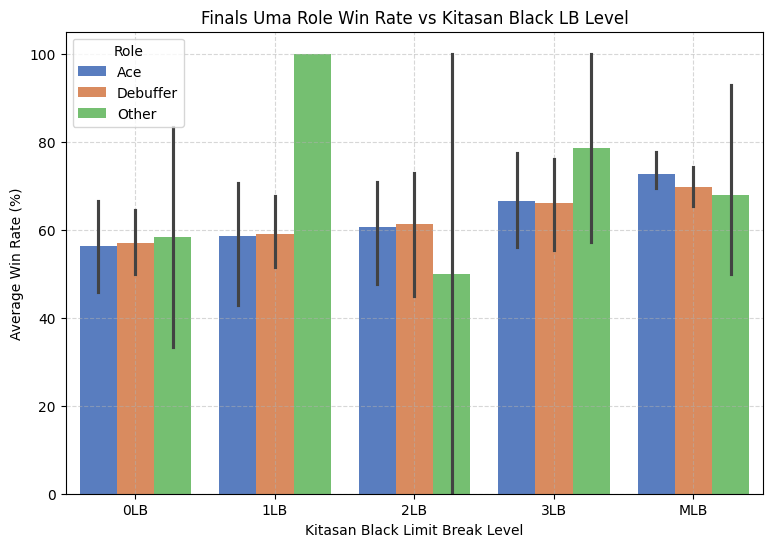

In [80]:
plt.figure(figsize=(9,6))
sns.barplot(data=role_lb_wr, x="Kitasan Black LB in Account (Non-borrow)",
            y="WinRate", hue="Role", palette="muted")
plt.title("Finals Uma Role Win Rate vs Kitasan Black LB Level")
plt.ylabel("Average Win Rate (%)")
plt.xlabel("Kitasan Black Limit Break Level")
plt.legend(title="Role")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


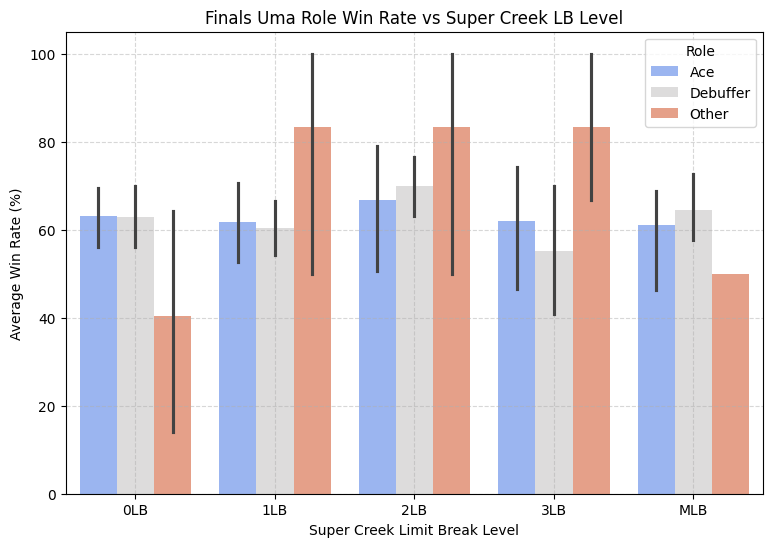

In [81]:
plt.figure(figsize=(9,6))
sns.barplot(data=role_lb_wr, x="Super Creek LB in Account (Non-borrow)",
            y="WinRate", hue="Role", palette="coolwarm")
plt.title("Finals Uma Role Win Rate vs Super Creek LB Level")
plt.ylabel("Average Win Rate (%)")
plt.xlabel("Super Creek Limit Break Level")
plt.legend(title="Role")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


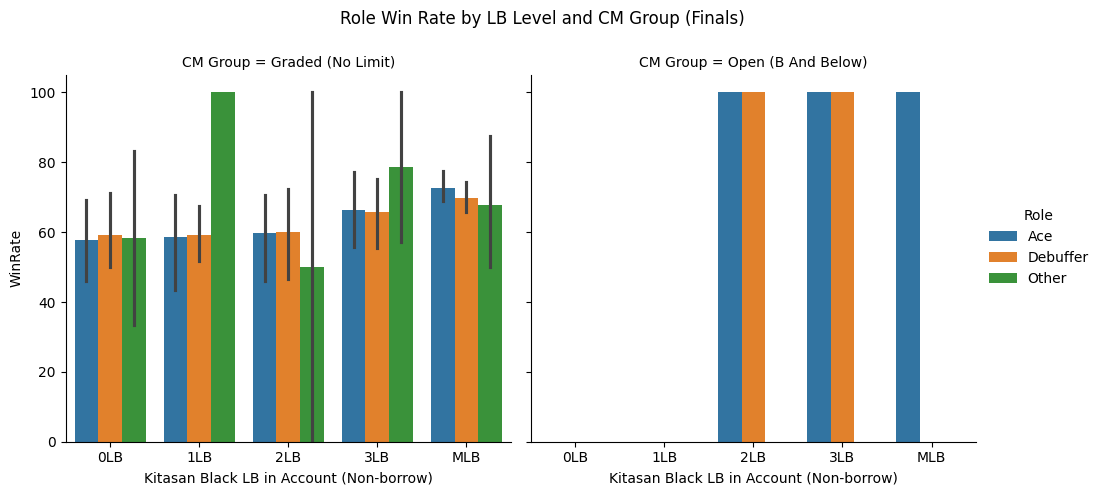

In [82]:
role_lb_wr_cm = (
    finals_entries.groupby(["CM Group",
                            "Role",
                            "Kitasan Black LB in Account (Non-borrow)",
                            "Super Creek LB in Account (Non-borrow)"])
    .agg(Appearances=("Uma", "count"),
         Wins=("Win", "sum"))
    .reset_index()
)

role_lb_wr_cm["WinRate"] = np.where(role_lb_wr_cm["Appearances"] > 0,
                                    (role_lb_wr_cm["Wins"] / role_lb_wr_cm["Appearances"]) * 100,
                                    np.nan).round(2)

sns.catplot(
    data=role_lb_wr_cm,
    x="Kitasan Black LB in Account (Non-borrow)", y="WinRate",
    hue="Role", col="CM Group",
    kind="bar", height=5, aspect=1
)
plt.subplots_adjust(top=0.85)
plt.suptitle("Role Win Rate by LB Level and CM Group (Finals)")
plt.show()


In [83]:
# Filter to keep valid Finals Uma data
finals_lb_uma = finals_entries.dropna(subset=["Uma", "Role", "Win"])

# Compute per Uma + Role + LB levels
uma_lb_wr = (
    finals_lb_uma.groupby(["Uma", "Role",
                           "Kitasan Black LB in Account (Non-borrow)",
                           "Super Creek LB in Account (Non-borrow)"])
    .agg(Appearances=("Uma", "count"),
         Wins=("Win", "sum"))
    .reset_index()
)

uma_lb_wr["WinRate"] = np.where(
    uma_lb_wr["Appearances"] > 0,
    (uma_lb_wr["Wins"] / uma_lb_wr["Appearances"]) * 100,
    np.nan
).round(2)

print(uma_lb_wr.head())


             Uma Role Kitasan Black LB in Account (Non-borrow)  \
0  Agnes Tachyon  Ace                                      0LB   
1  Agnes Tachyon  Ace                                      0LB   
2  Agnes Tachyon  Ace                                      0LB   
3  Agnes Tachyon  Ace                                      1LB   
4  Agnes Tachyon  Ace                                      1LB   

  Super Creek LB in Account (Non-borrow)  Appearances  Wins  WinRate  
0                                    0LB            6     3    50.00  
1                                    1LB            6     2    33.33  
2                                    2LB            1     1   100.00  
3                                    0LB            5     2    40.00  
4                                    1LB            1     0     0.00  


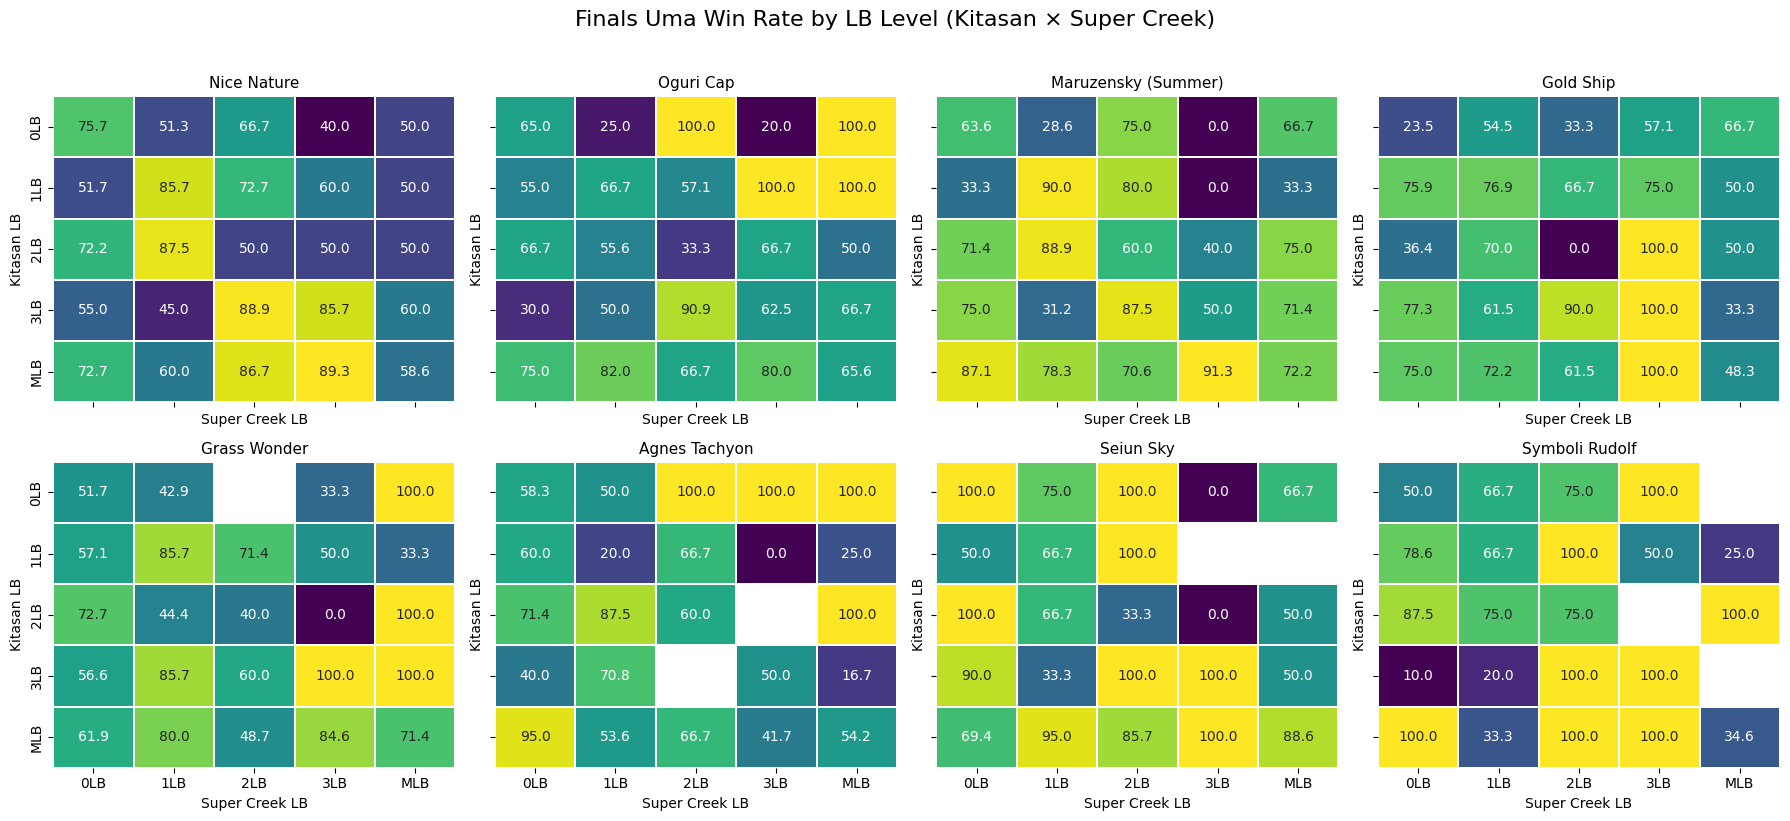

In [84]:
# Select most common Umas to plot
top_umas = (uma_lb_wr.groupby("Uma")["Appearances"]
            .sum().sort_values(ascending=False).head(8).index)

fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, uma in zip(axes, top_umas):
    subset = uma_lb_wr[uma_lb_wr["Uma"] == uma]
    if subset.empty:
        continue
    pivot = subset.pivot_table(index="Kitasan Black LB in Account (Non-borrow)",
                               columns="Super Creek LB in Account (Non-borrow)",
                               values="WinRate")
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis",
                cbar=False, ax=ax, linewidths=0.3)
    ax.set_title(f"{uma}", fontsize=11)
    ax.set_xlabel("Super Creek LB")
    ax.set_ylabel("Kitasan LB")

plt.suptitle("Finals Uma Win Rate by LB Level (Kitasan × Super Creek)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [85]:
# Ensure LB columns are numeric 0..4 (nullable Int64)
lb_map = {"0LB": 0, "1LB": 1, "2LB": 2, "3LB": 3, "MLB": 4}

for col in [
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)",
]:
    if col in finals_entries.columns:
        finals_entries[col] = (
            finals_entries[col]
            .map(lb_map)                      # map strings → ints
            .astype("Int64")                  # nullable integer
        )


In [86]:
# Keep valid rows
finals_lb_uma = finals_entries.dropna(
    subset=[
        "Uma", "Role", "Win",
        "Kitasan Black LB in Account (Non-borrow)",
        "Super Creek LB in Account (Non-borrow)"
    ]
).copy()

uma_lb_wr = (
    finals_lb_uma.groupby(
        ["Uma", "Role",
         "Kitasan Black LB in Account (Non-borrow)",
         "Super Creek LB in Account (Non-borrow)"],
        dropna=False
    )
    .agg(Appearances=("Uma", "count"),
         Wins=("Win", "sum"))
    .reset_index()
)

uma_lb_wr["WinRate"] = (
    (uma_lb_wr["Wins"] / uma_lb_wr["Appearances"]) * 100
).round(2)


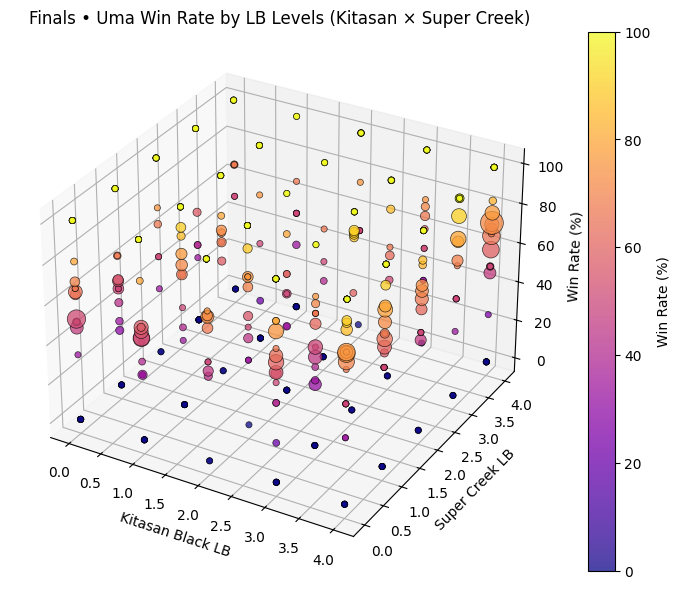

In [87]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

plot_df = uma_lb_wr.dropna(subset=[
    "Kitasan Black LB in Account (Non-borrow)",
    "Super Creek LB in Account (Non-borrow)",
    "WinRate"
]).copy()

# Convert nullable Int64 → float for plotting
plot_df["KitaLB"]  = plot_df["Kitasan Black LB in Account (Non-borrow)"].astype(float)
plot_df["CreekLB"] = plot_df["Super Creek LB in Account (Non-borrow)"].astype(float)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    plot_df["KitaLB"],
    plot_df["CreekLB"],
    plot_df["WinRate"],
    c=plot_df["WinRate"],
    cmap="plasma",
    s=np.clip(plot_df["Appearances"] * 5, 20, 400),
    alpha=0.75,
    edgecolor="black",
    linewidth=0.5
)

ax.set_xlabel("Kitasan Black LB")
ax.set_ylabel("Super Creek LB")
ax.set_zlabel("Win Rate (%)")
ax.set_title("Finals • Uma Win Rate by LB Levels (Kitasan × Super Creek)")
plt.colorbar(sc, label="Win Rate (%)")
plt.show()


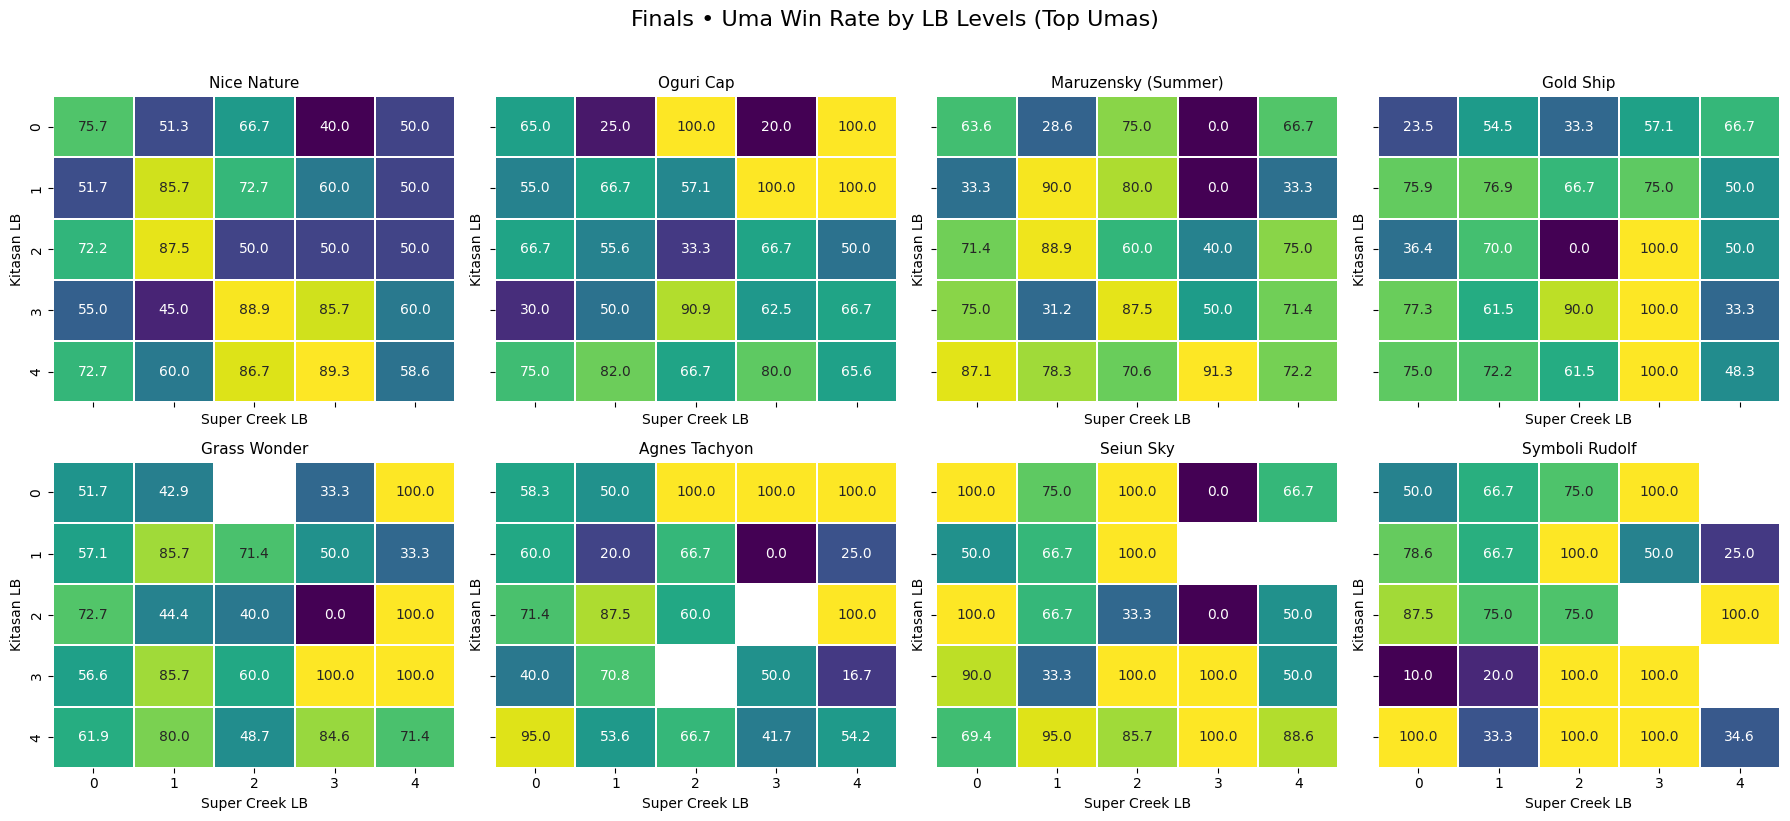

In [88]:
import seaborn as sns

top_umas = (uma_lb_wr.groupby("Uma")["Appearances"]
            .sum().sort_values(ascending=False).head(8).index)

fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, uma in zip(axes, top_umas):
    sub = uma_lb_wr[uma_lb_wr["Uma"] == uma]
    if sub.empty:
        ax.set_visible(False); continue
    pivot = sub.pivot_table(
        index="Kitasan Black LB in Account (Non-borrow)",
        columns="Super Creek LB in Account (Non-borrow)",
        values="WinRate"
    )
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis",
                cbar=False, ax=ax, linewidths=0.3)
    ax.set_title(uma, fontsize=11)
    ax.set_xlabel("Super Creek LB"); ax.set_ylabel("Kitasan LB")

plt.suptitle("Finals • Uma Win Rate by LB Levels (Top Umas)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [89]:
def plot_kitasan_heatmap(agg, top_n=30, title="Finals • Uma Win Rate by Kitasan LB (Debuffers Excluded)"):
    # Order Umas by total appearances
    order = (agg.groupby("Uma")["Appearances"].sum()
             .sort_values(ascending=False).index)
    if top_n is not None:
        order = order[:top_n]

    # Pivot to Uma × KitaLB
    pivot = (agg.pivot_table(index="Uma", columns="KitaLB", values="WinRate")
                .reindex(order))

    # Ensure KitaLB columns appear 0..4 in order (drop any unexpected levels)
    desired_cols = [0, 1, 2, 3, 4]
    existing_cols = [c for c in desired_cols if c in pivot.columns]
    pivot = pivot.reindex(columns=existing_cols)

    # Build a mask to hide NaNs and a custom annotation array with blanks for NaNs
    mask = pivot.isna()
    annot = pivot.copy()
    annot = annot.applymap(lambda v: "" if pd.isna(v) else f"{v:.1f}")

    plt.figure(figsize=(12, max(6, len(pivot.index)*0.35)))
    sns.heatmap(
        pivot, 
        annot=annot, fmt="",        # fmt="" because we pre-formatted text
        cmap="viridis", linewidths=0.3,
        cbar_kws={"label": "Win Rate (%)"},
        mask=mask                   # hide NaN cells and their annotations
    )
    plt.title(title)
    plt.xlabel("Kitasan Black LB")
    plt.ylabel("Uma")
    plt.tight_layout()
    plt.show()


In [90]:
# 🔧 EDIT ME: Uma → Debuffer Type
DEBUFF_TYPE = {
    # Speed debuffers
    "Grass Wonder": "Speed",
    "Symboli Rudolf": "Speed",
    "Agnes Tachyon": "Speed",

    # Stamina debuffers
    "Nice Nature": "Stamina",
    "Mayano Top Gun (Wedding)": "Stamina",

    # Other debuffers
    "Air Groove": "Other",
    # Add more as needed...
}

Finals — WR vs Total Debuffers
    Total_Debuffers      AvgWR  Teams
0                0  64.646465    198
1                1  61.047463    611
2                2  62.500000    224
3                3  57.142857      7

Finals — WR vs Debuffer Count Pattern
     Speed_Count  Stamina_Count  Other_Count Type_Pattern       AvgWR  Teams
8             1              1            1  S=1,T=1,O=1  100.000000      1
6             1              0            1  S=1,T=0,O=1   66.666667      3
10            2              0            0  S=2,T=0,O=0   65.882353     85
0             0              0            0  S=0,T=0,O=0   64.646465    198
5             1              0            0  S=1,T=0,O=0   64.503817    262
4             0              2            0  S=0,T=2,O=0   64.102564     39
3             0              1            1  S=0,T=1,O=1   60.000000      5
2             0              1            0  S=0,T=1,O=0   59.130435    345
7             1              1            0  S=1,T=1,O=0   

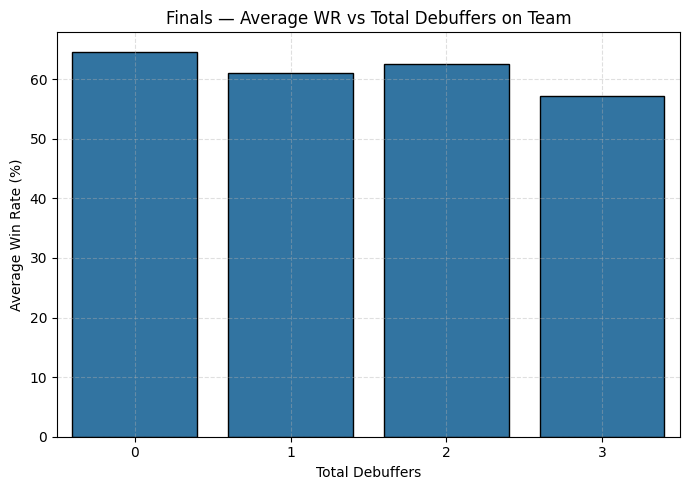

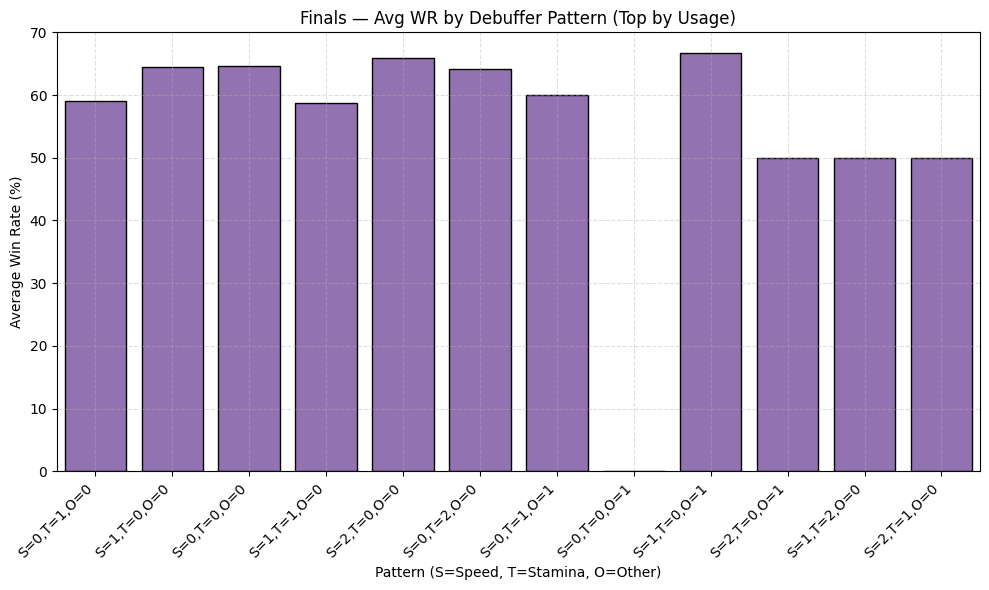

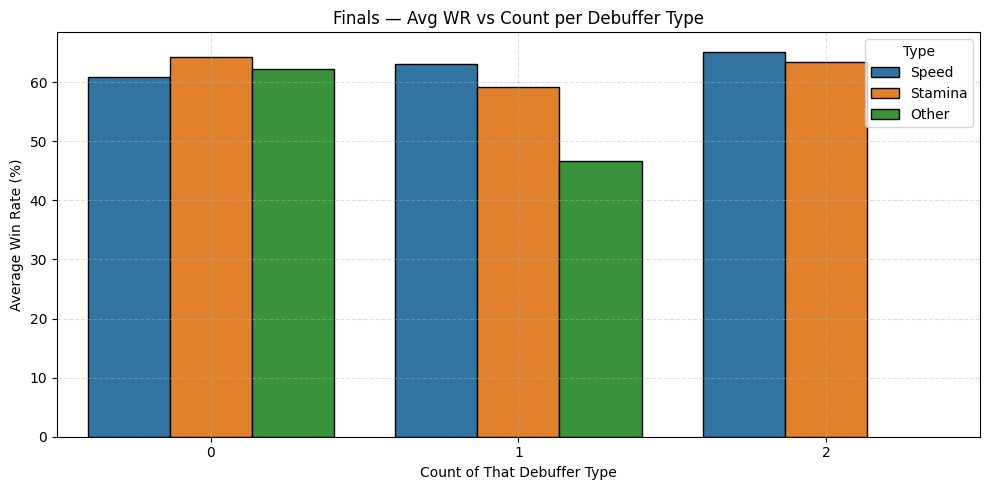

In [91]:
# --- Minimal role normalizer (Hybrid/Dominator -> Debuffer) if not defined ---
try:
    normalize_role
except NameError:
    def normalize_role(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if ("debuffer" in s) or ("hybrid" in s) or ("domin" in s):
            return "Debuffer"
        if "ace" in s:
            return "Ace"
        return "Other"

# --- Helper: count per-type debuffers on a single Finals row ---
def count_debuffers_final_row(row, debuff_map):
    speed = stamina = other = 0
    for i in (1, 2, 3):
        role = row.get(f"FINALS - Uma {i} Role", "")
        uma  = row.get(f"FINALS - Uma {i}", "")
        if isinstance(role, str) and (("debuffer" in role.lower()) or ("hybrid" in role.lower()) or ("domin" in role.lower())):
            uma_norm = str(uma).strip().title()
            t = debuff_map.get(uma_norm)
            if t == "Speed":
                speed += 1
            elif t == "Stamina":
                stamina += 1
            else:
                # Unknown debuffer in mapping -> treat as Other
                other += 1
    return speed, stamina, other

# --- Build team-level Finals dataframe ---
if "FINALS RESULTS" not in df.columns:
    raise KeyError("Missing 'FINALS RESULTS' in df.")

team_rows = []
for _, row in df.iterrows():
    result = str(row.get("FINALS RESULTS", "")).strip().upper()
    if result in ("", "N/A", "NA", "NONE", "NULL"):
        continue  # skip teams without a Finals result

    spd, sta, oth = count_debuffers_final_row(row, DEBUFF_TYPE)
    total = spd + sta + oth
    win = 1 if result == "1ST" else 0

    team_rows.append({
        "Wins": win,
        "Total": 1,
        "WinRate": win * 100.0,
        "Speed_Count": spd,
        "Stamina_Count": sta,
        "Other_Count": oth,
        "Total_Debuffers": total,
        # pattern string like "Speed=2, Stamina=1, Other=0"
        "Type_Pattern": f"S={spd},T={sta},O={oth}"
    })

finals_team_df = pd.DataFrame(team_rows)

# --- Summaries ---

# 1) WR vs Total debuffers (0..3)
wr_by_total = (
    finals_team_df.groupby("Total_Debuffers", as_index=False)
    .agg(AvgWR=("WinRate", "mean"),
         Teams=("WinRate", "count"))
    .sort_values("Total_Debuffers")
)

# 2) WR vs (Speed_Count, Stamina_Count, Other_Count) pattern
wr_by_pattern = (
    finals_team_df.groupby(["Speed_Count","Stamina_Count","Other_Count","Type_Pattern"], as_index=False)
    .agg(AvgWR=("WinRate", "mean"),
         Teams=("WinRate", "count"))
    .sort_values(["AvgWR","Teams"], ascending=[False, False])
)

# 3) WR vs each type's count separately (long format)
def _per_type_long(df, type_col, label):
    out = (df.groupby(type_col, as_index=False)
             .agg(AvgWR=("WinRate","mean"), Teams=("WinRate","count")))
    out.insert(0, "Type", label)
    out.rename(columns={type_col: "Count"}, inplace=True)
    return out

wr_speed_counts   = _per_type_long(finals_team_df, "Speed_Count",   "Speed")
wr_stamina_counts = _per_type_long(finals_team_df, "Stamina_Count", "Stamina")
wr_other_counts   = _per_type_long(finals_team_df, "Other_Count",   "Other")
wr_per_type_count = pd.concat([wr_speed_counts, wr_stamina_counts, wr_other_counts], ignore_index=True)

print("Finals — WR vs Total Debuffers\n", wr_by_total)
print("\nFinals — WR vs Debuffer Count Pattern\n", wr_by_pattern.head(12))
print("\nFinals — WR vs Per-Type Count (long)\n", wr_per_type_count)

# --- Optional: quick visuals ---
import matplotlib.pyplot as plt
import seaborn as sns

# A) Bar: Avg WR vs total debuffers
plt.figure(figsize=(7,5))
sns.barplot(data=wr_by_total, x="Total_Debuffers", y="AvgWR", color="tab:blue", edgecolor="black")
plt.title("Finals — Average WR vs Total Debuffers on Team")
plt.xlabel("Total Debuffers"); plt.ylabel("Average Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout(); plt.show()

# B) Bar: Avg WR by pattern (top 12 by Teams to keep readable)
top_patterns = wr_by_pattern.sort_values("Teams", ascending=False).head(12)
plt.figure(figsize=(10,6))
sns.barplot(data=top_patterns, x="Type_Pattern", y="AvgWR", edgecolor="black", color="tab:purple")
plt.title("Finals — Avg WR by Debuffer Pattern (Top by Usage)")
plt.xlabel("Pattern (S=Speed, T=Stamina, O=Other)"); plt.ylabel("Average Win Rate (%)")
plt.xticks(rotation=45, ha="right"); plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout(); plt.show()

# C) Faceted bars: per-type count curves
plt.figure(figsize=(10,5))
sns.barplot(data=wr_per_type_count, x="Count", y="AvgWR", hue="Type", edgecolor="black")
plt.title("Finals — Avg WR vs Count per Debuffer Type")
plt.xlabel("Count of That Debuffer Type"); plt.ylabel("Average Win Rate (%)")
plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout(); plt.show()

In [92]:
# Overwrite Finals Excel with the new detail
try:
    import xlsxwriter
    engine = "xlsxwriter"
except Exception:
    engine = "openpyxl"

out_xlsx = "data/processed/Finals_Debuffer_Analysis.xlsx"

with pd.ExcelWriter(out_xlsx, engine=engine, mode="w") as writer:
    # Core detail: every team’s debuffer counts (for auditing)
    finals_team_df.to_excel(writer, index=False, sheet_name="Finals_Team_Detail")

    # Summaries
    wr_by_total.to_excel(writer, index=False, sheet_name="WR_By_TotalDebuffers")
    wr_by_pattern.to_excel(writer, index=False, sheet_name="WR_By_TypePattern")
    wr_per_type_count.to_excel(writer, index=False, sheet_name="WR_PerType_Count")

    # Auto-fit columns if xlsxwriter
    if engine == "xlsxwriter":
        for sheet_name, df_ in {
            "Finals_Team_Detail": finals_team_df,
            "WR_By_TotalDebuffers": wr_by_total,
            "WR_By_TypePattern": wr_by_pattern,
            "WR_PerType_Count": wr_per_type_count,
        }.items():
            ws = writer.sheets[sheet_name]
            for col_idx, col in enumerate(df_.columns):
                max_len = max(len(str(col)), *(len(str(v)) for v in df_[col].astype(str).values[:1000]))
                ws.set_column(col_idx, col_idx, min(max_len + 2, 40))

print(f"✅ Finals Excel updated → {out_xlsx}")


✅ Finals Excel updated → data/processed/Finals_Debuffer_Analysis.xlsx
